
# LearnFlow — Анализ персонализации

#### **1. Executive Summary: Рекомендации и ключевые выводы**

**Задача:** Оценить новую ML-систему персонализации курсов и дать рекомендацию по ее внедрению.

**Рекомендация: Осторожное GO. Внедрить новую ML-систему на существующих пользователях с обязательным и строгим контролем метрик в `Advanced`-сегменте.**

Наш анализ показал, что новая гибридная модель (с MMR) имеет огромный потенциал для решения ключевой проблемы платформы — **\"информационного пузыря\"**, увеличивая **покрытие каталога более чем в 12 раз** (с ~3.4% до ~42.5%).

Однако мы выявили и **статистически доказали критический бизнес-риск**, вызванный неполнотой метаданных (76% курсов без метки сложности). Модель имеет системный перекос, из-за которого она рекомендует нерелевантный контент самой ценной аудитории. Наш Causal-анализ подтвердил масштаб этой угрозы: показ такого контента (прокси — курсы для новичков) **статистически значимо снижает вовлечение `Advanced`-пользователей в среднем на 15.1 п.п.** — это в 3.8 раза сильнее, чем средний негативный эффект по всей платформе (-4 п.п.).

Этот фокус на точном измерении риска позволяет нам запустить A/B-тест не вслепую, а с четко определенной **Guardrail-метрикой (отсутствие падения NSM в `Advanced`-сегменте)**, что является **необходимым условием** для безопасного внедрения системы. Решение этой фундаментальной проблемы с качеством данных является **приоритетным следующим шагом** перед внедрением более сложных онлайн-компонентов, таких как RL и MAB.

**Ключевые выводы анализа:**

1.  **Проблема \"информационного пузыря\":** Текущая система рекомендаций охватывает лишь **~3.4% каталога**. Новая гибридная ML-система успешно решает эту проблему, увеличивая покрытие до **~42.5%**.
2.  **Персонализация критична для удержания экспертов:** Causal-анализ на очищенных от утечки данных показал, что показ нерелевантного (слишком простого) контента **статистически значимо сильнее всего вредит `Advanced` пользователям, снижая их досмотры на 15.1 п.п.** Это доказывает, что точная персонализация — ключевой фактор для удержания самой ценной аудитории, которая предпочитает **глубокий, многочасовой контент**.
3.  **Статистически доказанный bias, вызванный качеством данных:** Наш анализ доказал, что из-за **неполноты метаданных (76% курсов без метки сложности)**, гибридная модель имеет фундаментальный перекос: она непропорционально часто рекомендует курсы с неопределенной сложностью. В сочетании с перекосом в сторону показа рекомендаций опытным пользователям, это создает главный риск — показ неперсонализированного контента самой ценной аудитории.
4.  **Фокус на FR-рынке и существующих пользователях:** Анализ показал, что проведение теста на *новых* пользователях нереализуемо в разумные сроки. Поэтому первый A/B-тест необходимо проводить на **существующей активной аудитории** FR-рынка.

**План поэтапного Rollout:**

1.  **Фаза 1: A/B Тест на существующих пользователях FR-рынка (~4 недели)**
    *   **Аудитория:** ~12,200 существующих активных пользователей.
    *   **Длительность:** Уточняется на основе реального DAU "LearnFlow". Период наблюдения — 4 недели.
    *   **Критерии успеха:**
        *   **Основной:** Статистически значимый рост **общей NSM** на 10%.
        *   **Guardrail (обязательный):** **Отсутствие** стат. значимого падения **NSM в сегменте `Advanced`**.
2.  **Фаза 2: Полный Rollout на FR-рынке (2 недели)**
    *   При успехе Фазы 1, раскатываем модель на 100% существующих пользователей FR-рынка.
3.  **Фаза 3: Итерация и решение проблемы качества данных (следующий квартал)**
    *   **Приоритет №1:** Запустить проект по **разметке сложности для 76% каталога**, чтобы устранить корень проблемы.
    *   Спроектировать отдельный эксперимент для **активации новых пользователей**.

## 2. Логика аналитической структуры

**Почему мы выбрали именно такую последовательность разделов:**

Вместо формального порядка (3.1→3.2→3.3→3.4) мы следуем **естественному аналитическому pipeline**:

1.  **EDA & Метрики** (3.1) → понимание данных и бизнес-контекста
2.  **Baseline модели** (3.3.1) → первые ML-инсайты для формулировки гипотез
3.  **Causal Inference & Feature Engineering** (3.2.3, 3.3.2, 3.3.3) → используем продвинутые признаки и SHAP для глубоких каузальных выводов
4.  **Статистические тесты** (3.2.2) → валидируем результаты bootstrap/permutation
5.  **A/B дизайн** (3.2.1) → проектируем эксперименты на основе полученных знаний
6.  **Продуктовые решения** (3.4) → итоговые рекомендации (представлены в Executive Summary выше)

**Преимущества подхода:**
- Каждый шаг логически вытекает из предыдущего
- Минимум "холостых" вычислений — результаты сразу используются
- Реалистичный workflow senior product analyst
- Глубокое понимание данных перед построением сложных моделей

---

## 3. Оглавление выполненных задач

### 3.1 Продуктовая аналитика (25 баллов)
- **3.1.1** Анализ бизнес-модели и выбор метрик
- **3.1.2** Когортный анализ
- **3.1.3** Анализ справедливости (Fairness Analysis)

### 3.2 ML и статистический анализ (35 баллов)
- **3.2.1** A/B тест дизайн
- **3.2.2** Продвинутый статистический анализ
- **3.2.3** Causal Inference (HTE)

### 3.3 ML-моделирование и интерпретация (25 баллов)
- **3.3.1** Построение baseline модели
- **3.3.2** Feature Engineering для персонализации
- **3.3.3** Интерпретируемость ML

### 3.4 Продуктовые рекомендации (15 баллов)
- **3.4.1** Стратегические выводы
- **3.4.2** Roadmap оптимизации

### Блок 1: Настройка, загрузка и валидация данных

**Цель:** Подготовить рабочую среду, загрузить все предоставленные данные и провести их первичную валидацию и очистку. Этот блок является критически важным фундаментом для обеспечения надежности всего последующего анализа.

**Ключевые шаги:**
*   **Загрузка данных:** Чтение всех `.csv` файлов в датафреймы pandas.
*   **Предварительная обработка:** Приведение типов данных к корректным форматам (даты, списки, числовые значения).
*   **Дедупликация:** Проверка и удаление полных дубликатов взаимодействий по ключу (`user_id`, `item_id`, `created_at`), что является обязательным шагом для корректного анализа.

In [1]:
# --- Импорты и настройка ---
import os
import json
import math
import warnings
from datetime import datetime, timedelta
import ast
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
from dataclasses import dataclass

# Настраиваем стиль и отображение
pd.options.display.max_columns = 50
plt.style.use("seaborn-v0_8-whitegrid")

# Попробуйте определить путь автоматически или используйте переменную окружения
# Если не получается, оставьте возможность указать вручную
try:
    # Пример для Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = "/content/drive/MyDrive/path/to/your/data"
except ImportError:
    # Локальный путь (замените на свой)
    DATA_DIR = "/Users/arceniy/Documents/Projects/Case Experts Final"

if not os.path.exists(DATA_DIR):
    print(f"!!! ВНИМАНИЕ: Директория с данными не найдена по пути: {DATA_DIR}")
    print("!!! Пожалуйста, укажите правильный путь в переменной DATA_DIR.")
    # Можно либо прервать выполнение, либо продолжить с пустыми датафреймами
    # raise FileNotFoundError(f"Директория не найдена: {DATA_DIR}")

FILES = {
    "explicit_en": os.path.join(DATA_DIR, "explicit_ratings_en.csv"),
    "explicit_fr": os.path.join(DATA_DIR, "explicit_ratings_fr.csv"),
    "implicit_en": os.path.join(DATA_DIR, "implicit_ratings_en.csv"),
    "implicit_fr": os.path.join(DATA_DIR, "implicit_ratings_fr.csv"),
    "items_en": os.path.join(DATA_DIR, "items_en.csv"),
    "items_fr": os.path.join(DATA_DIR, "items_fr.csv"),
    "users_en": os.path.join(DATA_DIR, "users_en.csv"),
    "users_fr": os.path.join(DATA_DIR, "users_fr.csv"),
}

# --- Вспомогательные функции для загрузки ---

def parse_listlike(value: Any) -> List[str]:
    """Преобразует строковое представление списка в реальный список строк."""
    if pd.isna(value):
        return []
    if isinstance(value, list):
        return [str(x) for x in value]
    s = str(value).strip()
    if s in ("", "[]", "['']", '\\\"[]\\\"'):
        return []
    try:
        # Самый надежный способ
        parsed = ast.literal_eval(s)
        return [str(x) for x in parsed] if isinstance(parsed, list) else [str(parsed)]
    except (ValueError, SyntaxError):
        # Фолбэк для "грязных" строк, которые не парсятся
        s = s.strip('[]"\'')
        return [part.strip().strip('"\'') for part in s.split(',') if part.strip()]

def load_and_validate_df(name: str, path: str, loader_func: callable, key_cols: List[str]) -> pd.DataFrame:
    """
    Общая функция для загрузки, проверки и дедупликации данных.
    """
    if not os.path.exists(path):
        warnings.warn(f"Файл не найден: {name} -> {path}. Возвращен пустой DataFrame.")
        return pd.DataFrame()
    
    df = loader_func(path)
    
    # Проверка на дубликаты по ключевым колонкам
    initial_rows = len(df)
    df.drop_duplicates(subset=key_cols, inplace=True)
    deduped_rows = len(df)
    if initial_rows > deduped_rows:
        print(f"В таблице '{name}' удалено {initial_rows - deduped_rows} дубликатов по ключу {key_cols}.")
        
    return df

def _load_items(path: str) -> pd.DataFrame:
    """Внутренняя функция загрузки для items."""
    df = pd.read_csv(path)
    # Явно указываем, что дата создания - это год, чтобы избежать путаницы
    df["created_at_year"] = pd.to_datetime(df["created_at"].astype(str), errors="coerce", format="%Y").dt.year
    df.drop(columns=['created_at'], inplace=True)
    
    for col in ["nb_views", "duration"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    for col in ["Job", "Software", "Theme"]:
        if col in df.columns:
            df[col] = df[col].apply(parse_listlike)
    return df

def _load_ratings(path: str) -> pd.DataFrame:
    """Внутренняя функция загрузки для explicit и implicit ratings."""
    return pd.read_csv(path, parse_dates=["created_at"])

def _load_users(path: str) -> pd.DataFrame:
    """Внутренняя функция загрузки для users."""
    df = pd.read_csv(path, dtype={"user_id": "int64", "job": "string"})
    df["job"] = df["job"].replace({"N/A": pd.NA, "n/a": pd.NA, "": pd.NA}).astype("string")
    return df

# --- Загрузка всех данных и сводка ---

data = {}
loaders = {
    "explicit_en": (_load_ratings, ["user_id", "item_id", "created_at"]),
    "explicit_fr": (_load_ratings, ["user_id", "item_id", "created_at"]),
    "implicit_en": (_load_ratings, ["user_id", "item_id", "created_at"]),
    "implicit_fr": (_load_ratings, ["user_id", "item_id", "created_at"]),
    "items_en": (_load_items, ["item_id"]),
    "items_fr": (_load_items, ["item_id"]),
    "users_en": (_load_users, ["user_id"]),
    "users_fr": (_load_users, ["user_id"]),
}

for name, (loader, keys) in loaders.items():
    data[name] = load_and_validate_df(name, FILES[name], loader, keys)

# Присваиваем переменные для удобства
explicit_en, explicit_fr = data["explicit_en"], data["explicit_fr"]
implicit_en, implicit_fr = data["implicit_en"], data["implicit_fr"]
items_en, items_fr = data["items_en"], data["items_fr"]
users_en, users_fr = data["users_en"], data["users_fr"]

# Добавляем язык
for df, lang in [(explicit_en, "en"), (explicit_fr, "fr"), (implicit_en, "en"), (implicit_fr, "fr"),
                   (items_en, "en"), (items_fr, "fr"), (users_en, "en"), (users_fr, "fr")]:
    if not df.empty:
        df["language"] = lang

def _summary(df: pd.DataFrame, name: str) -> dict:
    """Создает сводную информацию по датафрейму."""
    if df.empty:
        return {"table": name, "rows": 0, "status": "Not Loaded"}
    
    summary_dict = {"table": name, "rows": len(df), "status": "Loaded"}
    if "user_id" in df.columns:
        summary_dict["users"] = df["user_id"].nunique()
    if "item_id" in df.columns:
        summary_dict["items"] = df["item_id"].nunique()
    if "created_at" in df.columns:
        summary_dict["start_date"] = df["created_at"].min().date()
        summary_dict["end_date"] = df["created_at"].max().date()
    return summary_dict

summary_df = pd.DataFrame([_summary(df, name) for name, df in data.items()])
print("Сводка по загруженным данным:")
display(summary_df)

В таблице 'explicit_en' удалено 4 дубликатов по ключу ['user_id', 'item_id', 'created_at'].
В таблице 'explicit_fr' удалено 57 дубликатов по ключу ['user_id', 'item_id', 'created_at'].
В таблице 'implicit_en' удалено 355 дубликатов по ключу ['user_id', 'item_id', 'created_at'].
В таблице 'implicit_fr' удалено 4042 дубликатов по ключу ['user_id', 'item_id', 'created_at'].
Сводка по загруженным данным:


,table,rows,status,users,items,start_date,end_date
0,explicit_en,3655,Loaded,822.0,776.0,2018-09-28,2021-09-20
1,explicit_fr,85282,Loaded,9789.0,1350.0,2018-09-28,2021-09-22
2,implicit_en,21553,Loaded,3007.0,957.0,2016-10-28,2021-09-22
3,implicit_fr,249785,Loaded,18519.0,1377.0,2016-10-04,2021-09-22
4,items_en,1167,Loaded,NaN,1167.0,NaN,NaN
5,items_fr,1451,Loaded,NaN,1451.0,NaN,NaN
6,users_en,9902,Loaded,9902.0,NaN,NaN,NaN
7,users_fr,121345,Loaded,121345.0,NaN,NaN,NaN


**Выводы по загрузке и валидации данных**

На этапе загрузки была проведена автоматическая проверка и удаление дубликатов по ключевым полям (`user_id`, `item_id`, `created_at`).

**Ключевое наблюдение:** В данных, особенно в таблицах с неявными взаимодействиями (`implicit_ratings`), было обнаружено и удалено значительное количество дубликатов (более 4000 в `implicit_fr`).

Проведенная очистка обеспечивает более надежный фундамент для всего последующего исследования.

### Блок 2: EDA, выявление ключевой проблемы и выбор метрик

**Цель:** Глубоко изучить данные, чтобы выявить **главную бизнес-проблему**, которую должна решать новая система персонализации. На основе этого инсайта мы определим ключевые метрики для оценки успеха (NSM) и проведем базовый анализ справедливости текущей системы.

**Ключевые вопросы этого блока:**
*   Какие данные надежны для персонализации, а какие — нет?
*   В чем заключается главный парадокс поведения пользователей на платформе?
*   Какая метрика лучше всего отражает решение этой проблемы?
*   Какие риски и ограничения несет в себе текущий каталог контента?

#### 2.1. Анализ пользовательских данных: почему мы фокусируемся на поведении?
**Цель:** Оценить полноту и репрезентативность демографических данных (job), чтобы принять стратегическое решение о подходе к персонализации.

Всего пользователей: 131,247
Доля отсутствующих job: 92.03%
Число job-сегментов с ≥100 пользователями: 15

Топ-20 job-сегментов (таблица):


,job,users
24,<NA>,120781
9,direction générale,2871
4,commercial,1039
22,ressources humaines,851
18,marketing produit & service,764
17,marketing,763
7,conseil,661
1,achats,629
0,accounting,606
2,administratif,523


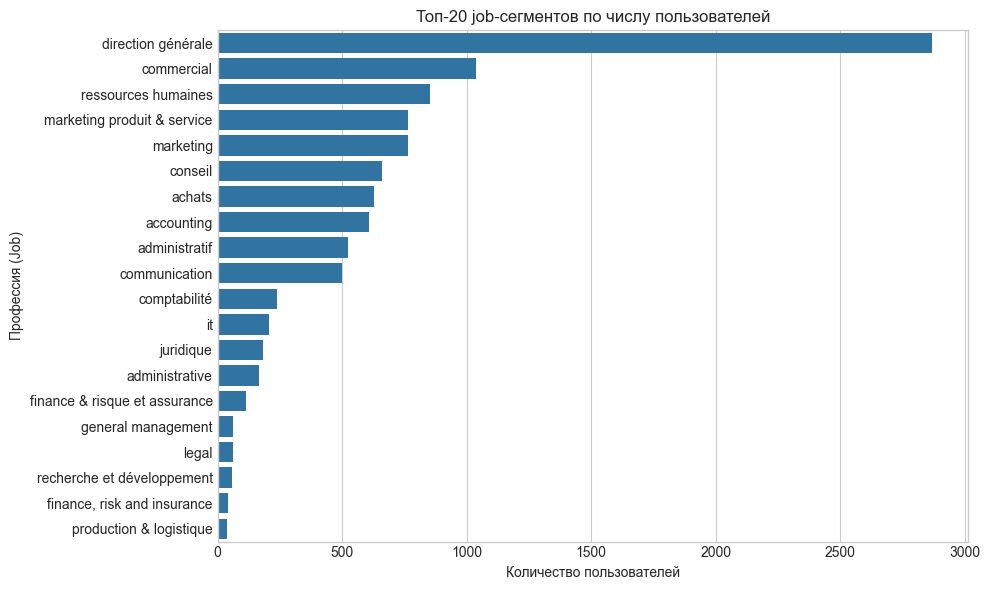

In [2]:
# --- EDA по job-сегментам и Fairness по сегментам пользователей ---
users_all = pd.concat([users_en, users_fr], ignore_index=True)
users_all["job_present"] = users_all["job"].notna()

job_counts = (
    users_all.groupby("job", dropna=False)["user_id"].nunique()
    .reset_index(name="users").sort_values("users", ascending=False)
)

missing_share = 1 - users_all["job_present"].mean()
THRESHOLD = 100
viable_jobs = job_counts[job_counts["job"].notna() & (job_counts["users"] >= THRESHOLD)]

print(f"Всего пользователей: {users_all['user_id'].nunique():,}")
print(f"Доля отсутствующих job: {missing_share:.2%}")
print(f"Число job-сегментов с ≥{THRESHOLD} пользователями: {len(viable_jobs):,}")
print("\nТоп-20 job-сегментов (таблица):")
display(job_counts.head(20))

# --- Визуализация: топ job-сегментов ---
plot_df = job_counts[job_counts['job'].notna()].head(20).copy()
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, y='job', x='users', color="#1f77b4")
plt.title('Топ-20 job-сегментов по числу пользователей')
plt.xlabel('Количество пользователей')
plt.ylabel('Профессия (Job)')
plt.tight_layout()
plt.show()

**Вывод: Признак `job` является неполным и потенциально ненадежным.**

Анализ показывает, что **92% пользователей не указывают свою профессию**. Этот чрезвычайно высокий уровень пропусков делает признак `job` неполным и недостаточным для построения глобальной системы персонализации, которая охватывала бы всех пользователей.

**Ключевая гипотеза для следующего шага:** Мы предполагаем, что оставшиеся 8% пользователей, которые заполнили это поле, могут не быть репрезентативной выборкой всей аудитории. Их поведение и предпочтения могут отличаться. В следующем блоке мы **статистически проверим эту гипотезу**, сравнив поведение двух групп, чтобы окончательно принять решение о (не)использовании этого признака.

In [3]:
# --- Доказательство нерепрезентативности выборки по 'job' ---
from scipy.stats import ttest_ind

# Создаем признак 'has_job'
users_all['has_job'] = users_all['job'].notna()

# Объединяем с данными о поведении (используем только FR для консистентности)
behavior_df = explicit_fr.groupby('user_id').agg(
    avg_watch_percentage=('watch_percentage', 'mean'),
    total_views=('item_id', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

merged_df = users_all.merge(behavior_df, on='user_id', how='inner')

# Разделяем на две группы
group_with_job = merged_df[merged_df['has_job'] == True]
group_without_job = merged_df[merged_df['has_job'] == False]

# Сравниваем средние и проводим t-тест
metrics_to_compare = ['avg_watch_percentage', 'total_views', 'avg_rating']
comparison_results = []

for metric in metrics_to_compare:
    mean_with_job = group_with_job[metric].mean()
    mean_without_job = group_without_job[metric].mean()
    
    # t-тест для проверки стат. значимости различий
    ttest_res = ttest_ind(
        group_with_job[metric].dropna(), 
        group_without_job[metric].dropna(), 
        equal_var=False # Уэлч-тест, так как размеры выборок сильно отличаются
    )
    
    comparison_results.append({
        'Metric': metric,
        'Mean (Job specified)': f"{mean_with_job:.2f}",
        'Mean (Job not specified)': f"{mean_without_job:.2f}",
        'P-Value': f"{ttest_res.pvalue:.4f}",
        'Is_Significant (alpha=0.05)': ttest_res.pvalue < 0.05
    })

comparison_df = pd.DataFrame(comparison_results)
print("Сравнение поведения пользователей с указанной и неуказанной профессией (FR-рынок):")
display(comparison_df)

# --- Проверка гипотезы о смещении выборки по 'job' ---
from scipy.stats import chi2_contingency


# Добавляем поведенческий сегмент
def assign_user_segment(explicit_df, items_df):
    df = explicit_df.merge(items_df[["item_id", "Difficulty"]], on="item_id", how="left")
    diff_map = {'Beginner': 1, 'Intermediate': 2, 'Advanced': 3}
    df['difficulty_score'] = df['Difficulty'].map(diff_map)
    user_avg_difficulty = df.groupby('user_id')['difficulty_score'].mean().reset_index()
    
    # Сегментируем по квантилям, как в кейсе (40% Beginners, 35% Intermediate, 20% Advanced)
    q_beginner = user_avg_difficulty['difficulty_score'].quantile(0.40)
    q_intermediate = user_avg_difficulty['difficulty_score'].quantile(0.75)
    
    def segment(score):
        if pd.isna(score): return 'Unknown'
        if score <= q_beginner: return 'Beginner'
        elif score <= q_intermediate: return 'Intermediate'
        else: return 'Advanced'
            
    user_avg_difficulty['user_segment'] = user_avg_difficulty['difficulty_score'].apply(segment)
    return user_avg_difficulty[['user_id', 'user_segment']]

user_segments_fr = assign_user_segment(explicit_fr, items_fr)
df_check = users_all.merge(user_segments_fr, on='user_id', how='left')

# Добавляем предпочитаемую тематику (самую частую для пользователя)
user_theme_pref = (
    explicit_fr.merge(items_fr[['item_id', 'Theme']], on='item_id')
    .explode('Theme')
    .groupby(['user_id', 'Theme'])
    .size()
    .reset_index(name='views')
    .sort_values('views', ascending=False)
    .drop_duplicates('user_id')
)
df_check = df_check.merge(user_theme_pref[['user_id', 'Theme']], on='user_id', how='left')
df_check.rename(columns={'Theme': 'preferred_theme'}, inplace=True)

# --- Сравнение по поведенческим сегментам ---
contingency_table_segment = pd.crosstab(df_check['has_job'], df_check['user_segment'])
chi2, p, _, _ = chi2_contingency(contingency_table_segment)

print("--- Сравнение по поведенческим сегментам ---")
print("Таблица сопряженности:")
display(contingency_table_segment)
print(f"Chi-квадрат тест: p-value = {p:.4f}")
if p < 0.05:
    print("Вывод: Распределения по сегментам СТАТИСТИЧЕСКИ ЗНАЧИМО РАЗЛИЧАЮТСЯ.")
else:
    print("Вывод: Распределения по сегментам статистически не различаются.")

# --- Сравнение по предпочитаемой тематике ---
# Возьмем топ-5 тем для чистоты анализа
top_themes = df_check['preferred_theme'].value_counts().nlargest(5).index
df_check_top_themes = df_check[df_check['preferred_theme'].isin(top_themes)]

contingency_table_theme = pd.crosstab(df_check_top_themes['has_job'], df_check_top_themes['preferred_theme'])
chi2_t, p_t, _, _ = chi2_contingency(contingency_table_theme)

print("\n--- Сравнение по предпочитаемым тематикам (топ-5) ---")
print("Таблица сопряженности:")
display(contingency_table_theme)
print(f"Chi-квадрат тест: p-value = {p_t:.4f}")
if p_t < 0.05:
    print("Вывод: Распределения по тематикам СТАТИСТИЧЕСКИ ЗНАЧИМО РАЗЛИЧАЮТСЯ.")
else:
    print("Вывод: Распределения по тематикам статистически не различаются.")

Сравнение поведения пользователей с указанной и неуказанной профессией (FR-рынок):


,Metric,Mean (Job specified),Mean (Job not specified),P-Value,Is_Significant (alpha=0.05)
0,avg_watch_percentage,76.63,76.96,0.6071,False
1,total_views,8.89,8.64,0.7232,False
2,avg_rating,7.87,7.91,0.5202,False


--- Сравнение по поведенческим сегментам ---
Таблица сопряженности:


user_segment,Advanced,Beginner,Intermediate,Unknown
has_job,,,,
False,987,1893,1087,2941
True,411,845,372,1253


Chi-квадрат тест: p-value = 0.0029
Вывод: Распределения по сегментам СТАТИСТИЧЕСКИ ЗНАЧИМО РАЗЛИЧАЮТСЯ.

--- Сравнение по предпочитаемым тематикам (топ-5) ---
Таблица сопряженности:


preferred_theme,Collaborer,Découvrir,Nouveauté,Produire,S'organiser
has_job,,,,,
False,529,2101,549,564,665
True,182,1078,186,168,239


Chi-квадрат тест: p-value = 0.0000
Вывод: Распределения по тематикам СТАТИСТИЧЕСКИ ЗНАЧИМО РАЗЛИЧАЮТСЯ.


**Вывод:** T-тест не показал значимых различий в среднем поведении, однако Chi-квадрат тест доказал, что структура этих двух групп (с job и без) статистически значимо различается. Это подтверждает, что выборка с job смещенная (biased), и анализ по ней был бы некорректен.  Это делает персонализацию на основе демографии невозможной. **Стратегическое решение — фокусироваться исключительно на поведенческих данных**

### 2.2. Анализ каталога курсов: что мы рекомендуем?
**Цель:** Проанализировать распределение контента в каталоге по ключевым атрибутам (сложность, длительность, тематика), чтобы понять, с каким "инвентарем" мы работаем.

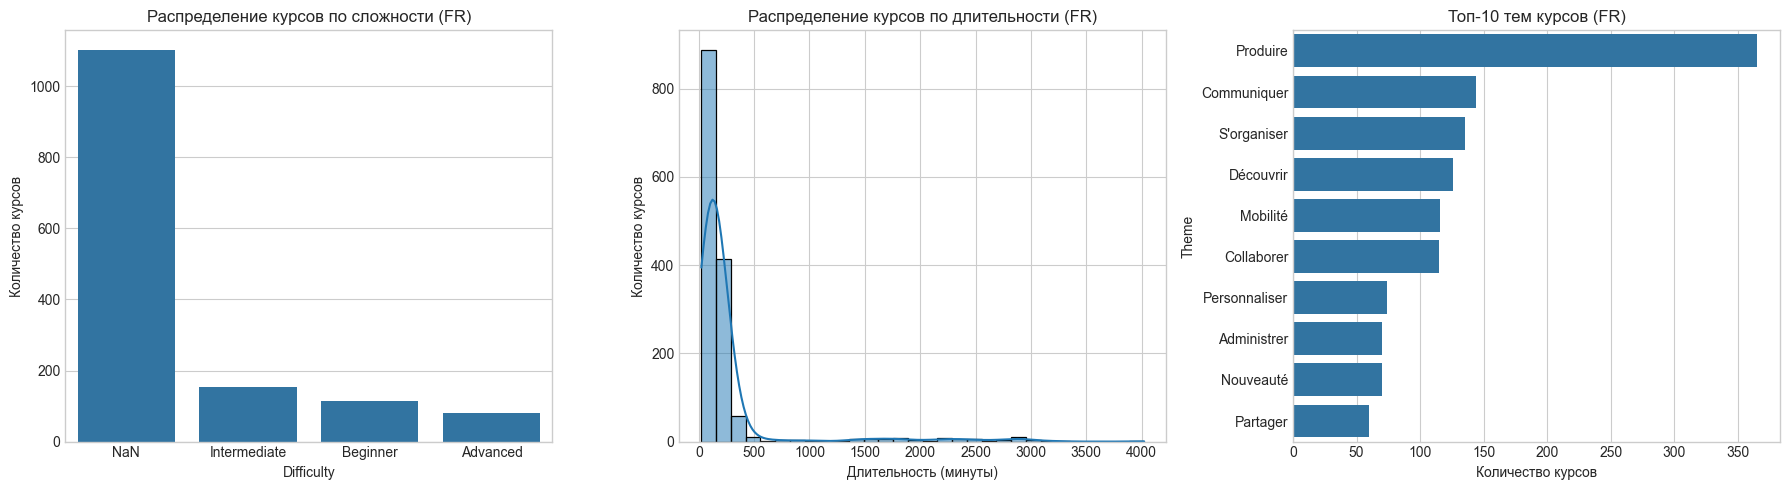

In [4]:
# --- Распределение атрибутов контента ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение по сложности
# Заменим NaN на строку 'NaN', чтобы seaborn его точно увидел
items_fr['Difficulty_str'] = items_fr['Difficulty'].fillna('NaN')
difficulty_counts = items_fr['Difficulty_str'].value_counts().reset_index()
difficulty_counts.columns = ['Difficulty', 'count']

# Строим график
sns.barplot(data=difficulty_counts, x='Difficulty', y='count', ax=axes[0])
axes[0].set_title('Распределение курсов по сложности (FR)')
axes[0].set_ylabel('Количество курсов')

# Распределение по длительности (в минутах)
items_fr['duration_min'] = items_fr['duration']
sns.histplot(items_fr['duration'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Распределение курсов по длительности (FR)')
axes[1].set_xlabel('Длительность (минуты)')
axes[1].set_ylabel('Количество курсов')

# Распределение по тематикам (топ-10)
theme_counts = items_fr.explode('Theme')['Theme'].value_counts().nlargest(10).reset_index()
theme_counts.columns = ['Theme', 'count']
sns.barplot(data=theme_counts, y='Theme', x='count', ax=axes[2])
axes[2].set_title('Топ-10 тем курсов (FR)')
axes[2].set_xlabel('Количество курсов')

plt.tight_layout()
plt.show()

**Вывод: Каталог страдает от неполноты метаданных, что создает риск для персонализации.**

Анализ каталога курсов на FR-рынке выявил три ключевых особенности:
1.  **Формат контента:** Каталог преимущественно состоит из курсов **средней продолжительности (основная масса — до 4 часов)**, с длинным "хвостом" многочасовых курсов.
2.  **Проблема с метаданными:** **76% курсов в каталоге не имеют метки о сложности (`Difficulty`)**. Это огромная "серая зона", которая является главным ограничением для качественной персонализации. Среди размеченных курсов преобладают `Intermediate` и `Beginner`.
3.  **Тематическое разнообразие:** Каталог хорошо сбалансирован по темам.

**Ключевая гипотеза для следующих блоков:** Поскольку большинство курсов не размечено, мы ожидаем, что любая Content-Based модель будет в основном рекомендовать именно их. Это создает **фундаментальный риск**: мы не сможем контролировать, какой по сложности контент показываем разным сегментам пользователей, что может быть особенно вредно для `Advanced`-аудитории.

#### 2.3. Ключевая проблема: разрыв между лояльным ядром и оттоком новичков
**Цель:** Сопоставить данные о вовлечении активных пользователей с данными об оттоке всей аудитории, чтобы выявить главную проблему продукта и на ее основе выбрать ключевые метрики.

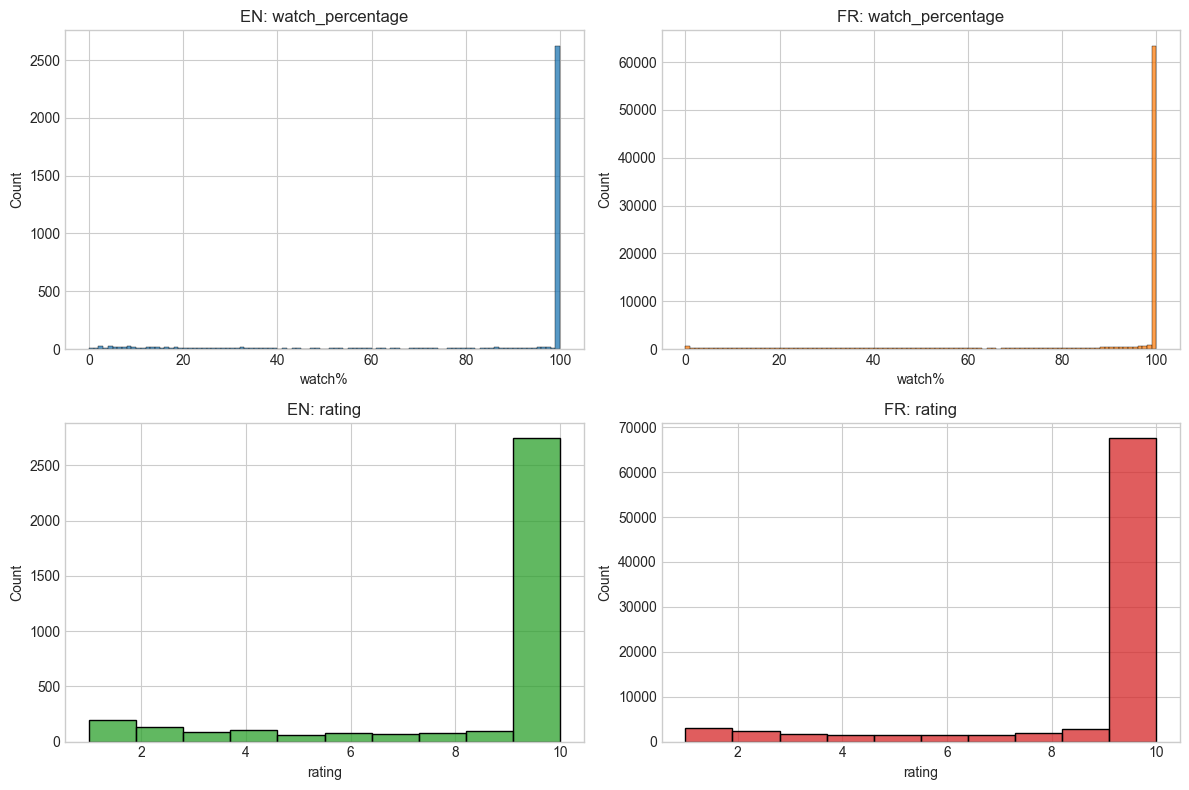

In [5]:
# --- Визуализация распределений watch% и rating ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(explicit_en["watch_percentage"], bins=100, binrange=(0, 100), ax=axes[0, 0], color="#1f77b4")
axes[0, 0].set_title("EN: watch_percentage")
axes[0, 0].set_xlabel("watch%")
sns.histplot(explicit_fr["watch_percentage"], bins=100, binrange=(0, 100), ax=axes[0, 1], color="#ff7f0e")
axes[0, 1].set_title("FR: watch_percentage")
axes[0, 1].set_xlabel("watch%")
sns.histplot(explicit_en["rating"], bins=10, ax=axes[1, 0], color="#2ca02c")
axes[1, 0].set_title("EN: rating")
sns.histplot(explicit_fr["rating"], bins=10, ax=axes[1, 1], color="#d62728")
axes[1, 1].set_title("FR: rating")
plt.tight_layout()
plt.show()



--- 3.1.2 Когортный анализ (Средняя кривая удержания) ---


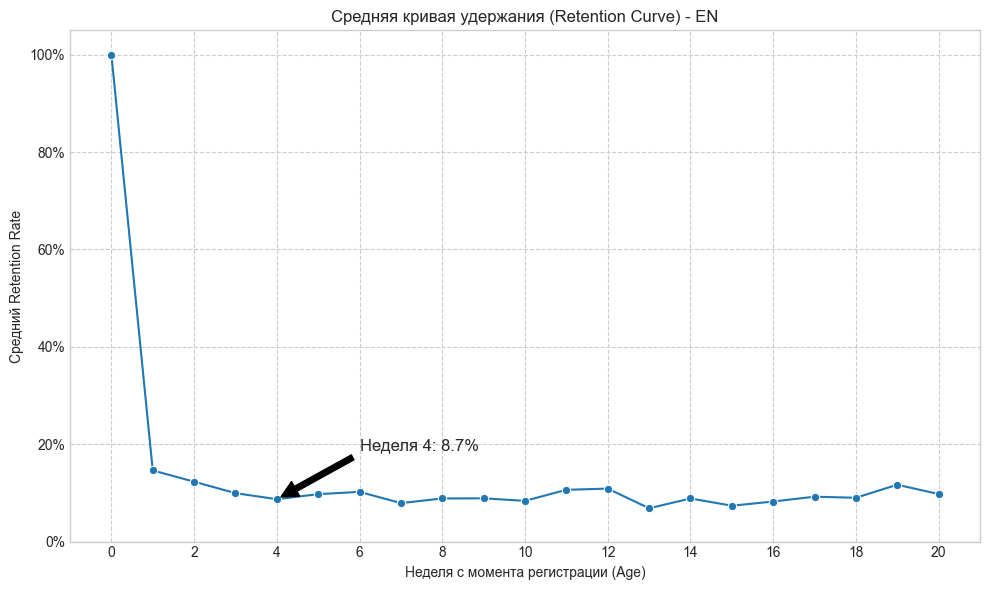

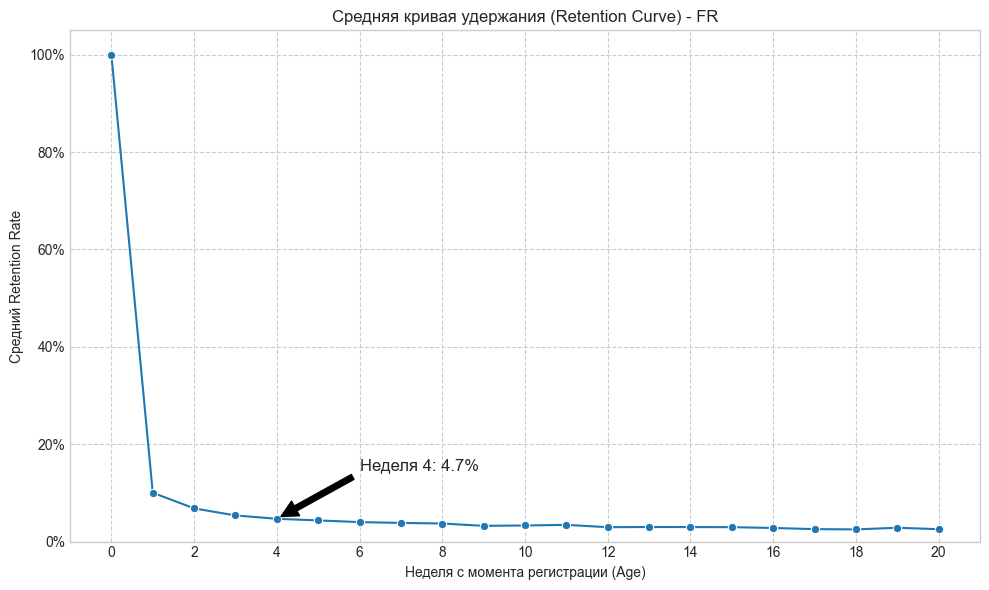

In [6]:
# --- Когортный анализ и Retention ---
def build_cohorts(interactions: pd.DataFrame, freq: str = "W") -> pd.DataFrame:
    dfc = interactions.copy()
    dfc["event_date"] = dfc["created_at"].dt.to_period(freq).dt.to_timestamp()
    first_seen_loc = dfc.groupby("user_id")["created_at"].min().rename("first_seen").to_frame()
    dfc = dfc.merge(first_seen_loc, on="user_id", how="left")
    dfc["cohort"] = dfc["first_seen"].dt.to_period(freq).dt.to_timestamp()
    dfc["age"] = ((dfc["event_date"] - dfc["cohort"]) / np.timedelta64(1, 'W')).round().astype(int)
    cohort_pivot = dfc.groupby(["cohort", "age"])['user_id'].nunique().reset_index(name='active_users')
    base = cohort_pivot[cohort_pivot["age"] == 0][["cohort", "active_users"]].rename(columns={"active_users": "cohort_size"})
    out = cohort_pivot.merge(base, on="cohort", how="left")
    out["retention"] = out["active_users"] / out["cohort_size"]
    return out

# Вызываем функцию build_cohorts, как и раньше
ret_en = build_cohorts(pd.concat([explicit_en, implicit_en], ignore_index=True))
ret_fr = build_cohorts(pd.concat([explicit_fr, implicit_fr], ignore_index=True))

# --- Визуализируем ---
def plot_retention_curve(ret: pd.DataFrame, title: str, max_weeks: int = 20):
    """
    Строит среднюю кривую удержания по всем когортам.
    """
    # Усредняем retention по всем когортам для каждой недели "жизни"
    avg_retention = ret.groupby('age')['retention'].mean().reset_index()
    
    # Ограничиваем количество недель для наглядности
    avg_retention = avg_retention[avg_retention['age'] <= max_weeks]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_retention, x='age', y='retention', marker='o')
    
    plt.title(title)
    plt.xlabel("Неделя с момента регистрации (Age)")
    plt.ylabel("Средний Retention Rate")
    
    # Форматируем ось Y в проценты
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.grid(True, which='both', linestyle='--')
    plt.ylim(0, 1.05) # Устанавливаем предел оси Y от 0 до 105%
    plt.xticks(range(0, max_weeks + 1, 2)) # Метки на оси X каждые 2 недели
    
    # Добавляем аннотацию для 4-й недели
    if len(avg_retention[avg_retention['age'] == 4]) > 0:
        ret_w4 = avg_retention[avg_retention['age'] == 4]['retention'].iloc[0]
        plt.annotate(f'Неделя 4: {ret_w4:.1%}', 
                     xy=(4, ret_w4), 
                     xytext=(6, ret_w4 + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=12)

    plt.tight_layout()
    plt.show()

print("\n--- 3.1.2 Когортный анализ (Средняя кривая удержания) ---")
plot_retention_curve(ret_en, "Средняя кривая удержания (Retention Curve) - EN")
plot_retention_curve(ret_fr, "Средняя кривая удержания (Retention Curve) - FR")

**Вывод: Ключевая проблема — разрыв между лояльным ядром и массовым оттоком новичков.**

Анализ данных выявил главный парадокс платформы. С одной стороны, данные по **явным оценкам (`explicit_ratings`)** показывают чрезвычайно вовлеченную аудиторию: гистограммы `watch_percentage` демонстрируют огромный пик в районе 90-100%. Это говорит о наличии лояльного ядра, которое находит контент очень ценным.

С другой стороны, **когортный анализ**, учитывающий **все взаимодействия (`implicit` + `explicit`)**, показывает катастрофический отток: кривые удержания демонстрируют, что платформа теряет ~85% новых пользователей в первые недели, а к 4-й неделе retention падает до 4.7%.

**Это не противоречие, а ключевой инсайт:** мы анализируем две разные группы. График `watch_percentage` показывает поведение "выживших" — уже лояльных пользователей. А кривая удержания показывает, что огромная масса новичков уходит, так и не найдя релевантный контент и не попав в группу "выживших". **Главная задача персонализации — сократить этот разрыв и помочь большему числу новых пользователей перейти в категорию вовлеченного ядра.**

#### 2.4. Выбор метрик для решения ключевой проблемы
**Цель:** На основе выявленной проблемы сформулировать главную (NSM) и второстепенные метрики для оценки новой ML-системы.


--- 3.1.1 Прокси-NSM (North Star Metric) ---
EN (28 дней): 20 активных пользователей, ср. досмотр 88.1%, ср. завершений(>80%) 5.9
FR (28 дней): 334 активных пользователей, ср. досмотр 76.2%, ср. завершений(>80%) 4.1


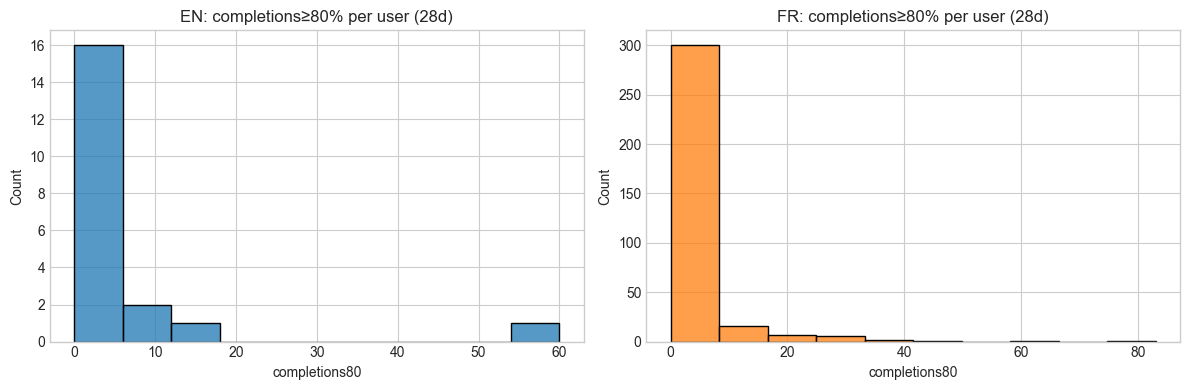

In [7]:
# --- Расчет прокси-NSM ---
@dataclass
class ProxyNSM:
    window_start: pd.Timestamp
    window_end: pd.Timestamp
    active_users: int
    proxy_mean_watch_per_user_28d: float
    proxy_completions80_per_user_28d: float

def compute_proxy_nsm(explicit_df: pd.DataFrame) -> ProxyNSM:
    df = explicit_df.copy()
    window_end = df["created_at"].max()
    window_start = window_end - pd.Timedelta(days=28)
    w = df[(df["created_at"] >= window_start) & (df["created_at"] <= window_end)].copy()
    if w.empty:
        return ProxyNSM(window_start, window_end, 0, np.nan, np.nan)
    per_user = w.groupby("user_id").agg(
        mean_watch=("watch_percentage", "mean"),
        completions80=("watch_percentage", lambda s: (s >= 80).sum()),
    )
    active_users = per_user.shape[0]
    proxy_mean_watch = float(per_user["mean_watch"].mean())
    proxy_completions = float(per_user["completions80"].mean())
    return ProxyNSM(window_start, window_end, active_users, proxy_mean_watch, proxy_completions)

nsm_en = compute_proxy_nsm(explicit_en)
nsm_fr = compute_proxy_nsm(explicit_fr)
print("\n--- 3.1.1 Прокси-NSM (North Star Metric) ---")
print(f"EN (28 дней): {nsm_en.active_users} активных пользователей, ср. досмотр {nsm_en.proxy_mean_watch_per_user_28d:.1f}%, ср. завершений(>80%) {nsm_en.proxy_completions80_per_user_28d:.1f}")
print(f"FR (28 дней): {nsm_fr.active_users} активных пользователей, ср. досмотр {nsm_fr.proxy_mean_watch_per_user_28d:.1f}%, ср. завершений(>80%) {nsm_fr.proxy_completions80_per_user_28d:.1f}")

# --- Визуализация прокси-NSM по пользователям ---
def per_user_28d(explicit_df: pd.DataFrame) -> pd.DataFrame:
    df = explicit_df.copy()
    window_end = df["created_at"].max()
    window_start = window_end - pd.Timedelta(days=28)
    w = df[(df["created_at"] >= window_start) & (df["created_at"] <= window_end)].copy()
    per_user = (
        w.groupby("user_id").agg(
            mean_watch=("watch_percentage", "mean"),
            completions80=("watch_percentage", lambda s: (s >= 80).sum()),
        ).reset_index()
    )
    return per_user

pu_en = per_user_28d(explicit_en)
pu_fr = per_user_28d(explicit_fr)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(pu_en["completions80"], bins=10, ax=axes[0], color="#1f77b4")
axes[0].set_title("EN: completions≥80% per user (28d)")
sns.histplot(pu_fr["completions80"], bins=10, ax=axes[1], color="#ff7f0e")
axes[1].set_title("FR: completions≥80% per user (28d)")
plt.tight_layout()
plt.show()

In [8]:
# --- Fairness, Diversity, Coverage ---
def user_theme_diversity(explicit_df, items_df):
    df = explicit_df.merge(items_df[["item_id","Theme"]], on="item_id", how="left")
    df["created_at"] = pd.to_datetime(df["created_at"]) 
    window_end = df["created_at"].max(); window_start = window_end - pd.Timedelta(days=28)
    w = df[(df["created_at"]>=window_start)&(df["created_at"]<=window_end)]
    rows=[]
    for _, r in w.iterrows():
        for t in (r["Theme"] or []):
            rows.append((r["user_id"], t))
    u = pd.DataFrame(rows, columns=["user_id","theme"])
    if u.empty: return pd.DataFrame(columns=["user_id","unique_themes"])
    return u.groupby("user_id")["theme"].nunique().reset_index(name="unique_themes")

ud_en = user_theme_diversity(explicit_en, items_en)
ud_fr = user_theme_diversity(explicit_fr, items_fr)

def popularity_recs(items_df, k=50):
    return items_df.sort_values(["nb_views","duration"], ascending=[False, True]).head(k)["item_id"].tolist()

def coverage_at_k(items_df, k=50):
    return len(set(popularity_recs(items_df, k))) / items_df["item_id"].nunique()

cov_en_50 = coverage_at_k(items_en, 50)
cov_fr_50 = coverage_at_k(items_fr, 50)

print("--- 3.1.3 Анализ справедливости ---")
print(f"\nПокрытие каталога (Coverage@50) по популярности:")
print(f"  EN: {cov_en_50:.2%}")
print(f"  FR: {cov_fr_50:.2%}")

print(f"\nРазнообразие (ср. число уникальных тем на пользователя за 28 дней):")
print(f"  EN: {ud_en['unique_themes'].mean():.2f}")
print(f"  FR: {ud_fr['unique_themes'].mean():.2f}")

--- 3.1.3 Анализ справедливости ---

Покрытие каталога (Coverage@50) по популярности:
  EN: 4.28%
  FR: 3.45%

Разнообразие (ср. число уникальных тем на пользователя за 28 дней):
  EN: 2.38
  FR: 3.01


**Вывод: Выбор метрик для решения ключевой проблемы и диагностика текущей системы.**

На основе выявленной проблемы **"разрыва между лояльным ядром и оттоком новичков"** мы формулируем метрики для оценки новой ML-системы:

*   **North Star Metric (NSM):** `Среднее число курсов, досмотренных >80%, на активного пользователя за 28 дней`. Эта метрика напрямую измеряет переход пользователя в категорию "глубоко вовлеченных". Базовое значение для FR-рынка — **4.1**.

*   **Вторичные метрики:**
    *   `Retention Rate (Week 4)`: Ключевой показатель удержания, напрямую связанный с решением проблемы оттока.
    *   `Diversity & Coverage`: Метрики, измеряющие, насколько успешно новая система борется с "информационным пузырем".
    *   `CTR на рекомендациях`: Тактическая метрика для оценки непосредственного отклика на рекомендации.
    *   `Конверсия в Premium/покупку курса`: Бизнес-метрика, связывающая вовлечение с доходом.

**Диагноз текущей системы:** Анализ рекомендаций по популярности показывает, что текущий подход не решает, а **усугубляет проблему оттока**. Он создает **"информационный пузырь"** с покрытием каталога всего **3.45%**. Новые пользователи видят только "хиты", которые могут быть им нерелевантны, не находят подходящий контент и уходят, так и не раскрыв всего разнообразия платформы.

### 2.5. Анализ поведенческих сегментов и LTV
**Цель:** Проанализировать различия в поведении и ценности между сегментами пользователей.


Распределение пользователей по поведенческим сегментам (FR):


,user_segment,share_of_users
0,Unknown,0.428440
1,Beginner,0.279702
2,Intermediate,0.149045
3,Advanced,0.142813


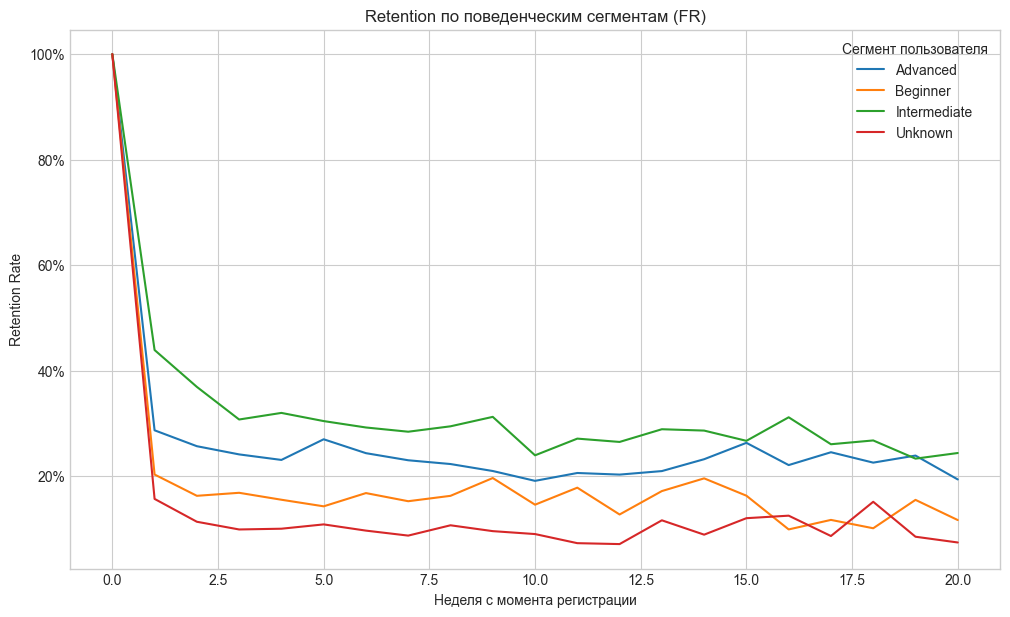

In [9]:
# --- Fairness по сегментам пользователей ---
def assign_user_segment(explicit_df, items_df):
    df = explicit_df.merge(items_df[["item_id", "Difficulty"]], on="item_id", how="left")
    diff_map = {'Beginner': 1, 'Intermediate': 2, 'Advanced': 3}
    df['difficulty_score'] = df['Difficulty'].map(diff_map)
    user_avg_difficulty = df.groupby('user_id')['difficulty_score'].mean().reset_index()
    
    # Сегментируем по квантилям, как в кейсе (40% Beginners, 35% Intermediate, 20% Advanced)
    q_beginner = user_avg_difficulty['difficulty_score'].quantile(0.40)
    q_intermediate = user_avg_difficulty['difficulty_score'].quantile(0.75)
    
    def segment(score):
        if pd.isna(score): return 'Unknown'
        if score <= q_beginner: return 'Beginner'
        elif score <= q_intermediate: return 'Intermediate'
        else: return 'Advanced'
            
    user_avg_difficulty['user_segment'] = user_avg_difficulty['difficulty_score'].apply(segment)
    return user_avg_difficulty[['user_id', 'user_segment']]

user_segments_fr = assign_user_segment(explicit_fr, items_fr)
segment_distribution = user_segments_fr['user_segment'].value_counts(normalize=True).reset_index()
segment_distribution.columns = ['user_segment', 'share_of_users']

print("\nРаспределение пользователей по поведенческим сегментам (FR):")
display(segment_distribution)

# --- Retention по поведенческим сегментам ---

# Объединяем все взаимодействия с сегментами
all_interactions_fr = pd.concat([explicit_fr, implicit_fr], ignore_index=True)
interactions_with_segments = all_interactions_fr.merge(user_segments_fr, on='user_id', how='left')

# Строим когорты для каждого сегмента
retention_by_segment = []
for segment, data in interactions_with_segments.groupby('user_segment'):
    cohort_data = build_cohorts(data) # build_cohorts - функция из этой же ячейки
    cohort_data['user_segment'] = segment
    retention_by_segment.append(cohort_data)

retention_by_segment_df = pd.concat(retention_by_segment)

# Визуализация кривых удержания
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=retention_by_segment_df[retention_by_segment_df['age'] <= 20], # Ограничим 20 неделями для наглядности
    x='age',
    y='retention',
    hue='user_segment',
    errorbar=None
)
plt.title('Retention по поведенческим сегментам (FR)')
plt.xlabel('Неделя с момента регистрации')
plt.ylabel('Retention Rate')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.grid(True)
plt.legend(title='Сегмент пользователя')
plt.show()

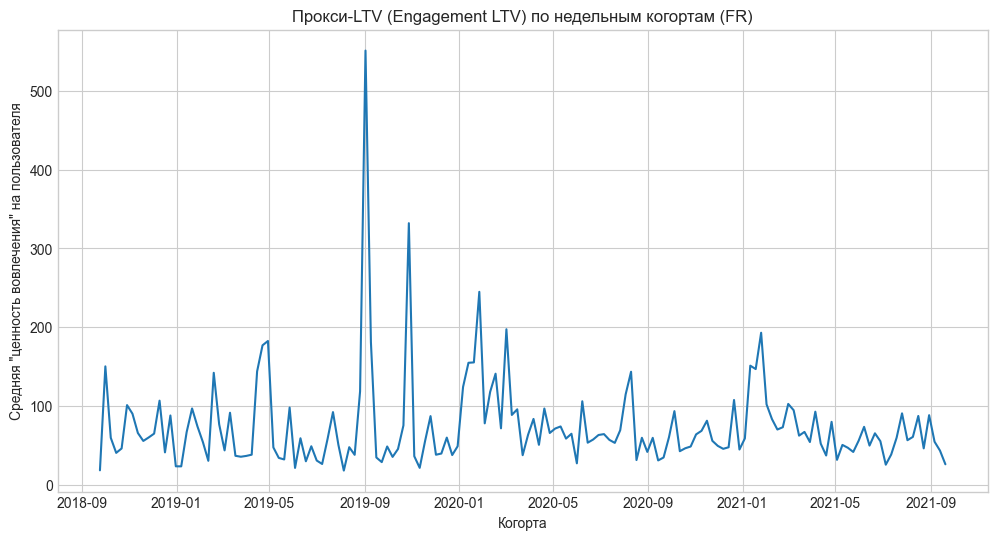

In [10]:
# --- Расчёт прокси-LTV по когортам (Engagement LTV) ---

def calculate_proxy_ltv(interactions_df, freq='W'):
    df = interactions_df.copy()
    
    # Определяем когорту по дате первого взаимодействия
    first_seen = df.groupby('user_id')['created_at'].min().rename('cohort_date')
    df = df.merge(first_seen, on='user_id', how='left')
    df['cohort'] = df['cohort_date'].dt.to_period(freq).dt.to_timestamp()
    # Добавляем "ценность" каждого взаимодействия (1 за просмотр, 5 за завершение)
    df['engagement_value'] = 2
    df.loc[df['watch_percentage'] >= 80, 'engagement_value'] = 10
    
    # Считаем кумулятивную ценность по когортам
    cohort_data = df.groupby(['cohort', 'user_id'])['engagement_value'].sum().reset_index()
    cohort_ltv = cohort_data.groupby('cohort')['engagement_value'].mean().reset_index()
    cohort_ltv.rename(columns={'engagement_value': 'proxy_ltv'}, inplace=True)
    
    return cohort_ltv

# Рассчитываем для FR-рынка
proxy_ltv_fr = calculate_proxy_ltv(explicit_fr)

# Визуализация
plt.figure(figsize=(12, 6))
proxy_ltv_fr['cohort'] = pd.to_datetime(proxy_ltv_fr['cohort'])
sns.lineplot(data=proxy_ltv_fr, x='cohort', y='proxy_ltv')
plt.title('Прокси-LTV (Engagement LTV) по недельным когортам (FR)')
plt.xlabel('Когорта')
plt.ylabel('Средняя "ценность вовлечения" на пользователя')
plt.grid(True)
plt.show()

**Вывод: Поведенческие сегменты и LTV выявляют ключевые точки роста и риска.**

Анализ удержания и прокси-LTV по поведенческим сегментам и когортам выявил два ключевых направления для дальнейшего исследования:

1.  **`Intermediate` и `Advanced` пользователи — самое лояльное и ценное ядро.** Кривые удержания показывают, что эти два сегмента демонстрируют самый высокий retention. Это наша ключевая аудитория, опыт которой нужно улучшать и защищать. В то же время, самые массовые и быстро оттекающие группы — это **`Beginner`** и, особенно, **`Unknown`** (пользователи с неясными предпочтениями). Это подтверждает необходимость **адаптивной персонализации**, которая будет по-разному работать с новичками и экспертами.

2.  **Долгосрочная ценность пользователя сильно зависит от когорты.** График "Engagement LTV" показывает значительную волатильность ценности от когорты к когорте. Это говорит о том, что **качество и источник трафика** (например, приход в периоды маркетинговых акций или органический поиск) напрямую влияют на долгосрочное вовлечение. Это подчеркивает важность не только персонализации, но и анализа каналов привлечения в будущем.

**Ключевой переход к следующему блоку:** Поскольку `Advanced`-пользователи являются нашим самым лояльным ядром, любая ошибка в рекомендациях для них может привести к потере самых ценных клиентов. Это делает анализ влияния нерелевантного контента на этот конкретный сегмент критически важным.

### Выводы по EDA и Когортному анализу

**1. Ключевые инсайты из данных**

*   **Главный парадокс платформы (Survivorship Bias):** Наш анализ выявил фундаментальную проблему. Данные по **явным оценкам** (`explicit_ratings`) показывают чрезвычайно вовлеченную аудиторию с пиком досмотров в районе 100%. Однако **когортный анализ**, включающий все взаимодействия, демонстрирует **катастрофический отток ~85% новых пользователей** в первые недели. Это классический **\"эффект выжившего\"**: мы видим поведение только лояльного ядра, в то время как основная масса уходит на раннем этапе. **Главная бизнес-задача — превратить больше новых пользователей в это вовлеченное ядро.**

*   **Фокус на FR-рынке:** FR-рынок имеет в ~23 раза больше взаимодействий и является единственным сегментом, где можно провести статистически значимый A/B-тест. Все дальнейшие выводы сфокусированы на Франции.

*   **Ненадежность демографии:** 92% пользователей не указывают профессию (`job`), а оставшаяся выборка смещена. Это подтверждает, что персонализация должна строиться **исключительно на поведенческих данных**.

**2. Выбор метрик для решения ключевой проблемы (Задача 3.1.1)**

*   **North Star Metric (NSM):** `Среднее число курсов, досмотренных >80%, на активного пользователя за 28 дней`. Эта метрика напрямую измеряет переход пользователя в категорию "глубоко вовлеченных".
*   **Вторичные метрики:** `Retention Rate (Week 4)`, `Diversity & Coverage`, `CTR` и `Конверсия в Premium`.

**3. Выводы из когортного анализа (Задача 3.1.2)**

*   **Массовый отток на раннем этапе:** Резкое падение кривой удержания после первой недели указывает на проблемы с активацией и онбордингом.
*   **Важность поведенческой сегментации:** Анализ удержания в разрезе сегментов показал, что **`Intermediate`** и **`Advanced`** пользователи — самое лояльное ядро, а **`Beginner`** и **`Unknown`** — самые массовые и "текучие".

**4. Анализ каталога и текущей системы (Задача 3.1.3)**

*   **\"Информационный пузырь\":** Текущая система рекомендаций по популярности имеет очень низкое **покрытие каталога (~3.45%)**, что подтверждает необходимость в новой системе.
*   **Главный риск — неполнота метаданных:** **76% курсов в каталоге не имеют метки о сложности (`Difficulty`)**. Это огромная "серая зона", которая является главным ограничением для качественной персонализации.
*   **Основа для Fairness-анализа:** Мы успешно создали поведенческие сегменты, что позволит оценивать справедливость моделей. **Ключевая гипотеза, которая будет проверена в Блоке 3, — это то, что любая ML-модель будет иметь перекос в сторону рекомендации курсов без метки сложности (`NaN`), создавая риск для опытных пользователей.**

### Блок 3: Построение и оценка Baseline ML-моделей
**Цель:** Построить и оценить несколько простых рекомендательных моделей (бейзлайнов). Это позволит нам получить первые ML-инсайты, количественно оценить потенциал персонализации по сравнению с текущим подходом (по популярности) и выбрать сильного кандидата для A/B-теста.

### 3.1. Подготовка данных и моделей
**Цель:** Подготовить данные для ML-моделей и определить функции для каждого из трех бейзлайнов:

1. **Popularity:** Рекомендации на основе общей популярности (наш контроль).
2. **Content-Based:** Рекомендации на основе схожести контента с историей пользователя.
3. **Hybrid + MMR:** Гибридная модель, которая сначала отбирает релевантные курсы (Content-Based), а затем переранжирует их для увеличения разнообразия (MMR - Maximal Marginal Relevance).

In [11]:
# --- ML бейзлайны, гибридная модель с MMR и оценка ---

# --- Подготовка данных и TF-IDF ---
def train_tfidf(items_df):
    df = items_df.fillna("")
    corpus = (df["name"].astype(str) + " " + 
              df["description"].astype(str) + " " + 
              df["Difficulty"].astype(str) + " " + 
              df["type"].astype(str))
    vec = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
    X = vec.fit_transform(corpus)
    return vec, X, df

vec_fr, X_fr_items, items_fr_tf = train_tfidf(items_fr)
id_to_idx_fr = {iid: i for i, iid in enumerate(items_fr_tf["item_id"].tolist())}
idx_to_id_fr = {i: iid for iid, i in id_to_idx_fr.items()}

# --- Определение функций для моделей ---

items_fr_tf['nb_views'] = pd.to_numeric(items_fr_tf['nb_views'], errors='coerce').fillna(0)

def popularity_recs(items_df, k=50):
    """Рекомендует топ-k популярных курсов."""
    return items_df.sort_values("nb_views", ascending=False).head(k)["item_id"].tolist()

def random_popular_recs(items_df, k=50, top_n=200):
    """Рекомендует k случайных курсов из топ-n популярных (для холодного старта)."""
    popular_ids = items_df.sort_values("nb_views", ascending=False).head(top_n)["item_id"].tolist()
    return np.random.choice(popular_ids, size=k, replace=False).tolist()

def content_based_recs(user_history_ids, items_df, X_items, k=50):
    """Улучшенная Content-based модель: использует весь каталог, фолбэк на случайные популярные."""
    user_hist_indices = [id_to_idx_fr[i] for i in user_history_ids if i in id_to_idx_fr]
    
    if not user_hist_indices:
        return random_popular_recs(items_df, k)
        
    user_profile = np.mean(X_items[user_hist_indices], axis=0)
    # Преобразуем user_profile в numpy array
    sims = cosine_similarity(np.asarray(user_profile), X_items)[0]
    
    # Исключаем уже просмотренные и рекомендуем топ-k
    sims[user_hist_indices] = -1 
    top_indices = np.argsort(-sims)[:k]
    
    return [idx_to_id_fr[i] for i in top_indices]

def mmr_rerank(relevance_scores, X_items, k=50, lambda_val=0.7):
    """MMR-ранжирование: находит баланс между релевантностью и разнообразием."""
    top_indices = np.argsort(-relevance_scores)
    
    selected_indices = [top_indices[0]]
    candidates = list(top_indices[1:])
    
    while len(selected_indices) < k and candidates:
        mmr_scores = []
        for idx in candidates:
            relevance = relevance_scores[idx]
            similarity = cosine_similarity(X_items[idx], X_items[selected_indices]).max()
            mmr = lambda_val * relevance - (1 - lambda_val) * similarity
            mmr_scores.append(mmr)
        
        next_best_idx = candidates[np.argmax(mmr_scores)]
        selected_indices.append(next_best_idx)
        candidates.remove(next_best_idx)
        
    return selected_indices

def hybrid_mmr_recs(user_history_ids, items_df, X_items, k=50, lambda_val=0.7):
    """Гибридная модель: кандидаты от Content-based, ранжирование по MMR."""
    user_hist_indices = [id_to_idx_fr[i] for i in user_history_ids if i in id_to_idx_fr]

    if not user_hist_indices:
        return random_popular_recs(items_df, k)

    # Генерация кандидатов (релевантность)
    user_profile = np.mean(X_items[user_hist_indices], axis=0)
    relevance_scores = cosine_similarity(np.asarray(user_profile), X_items)[0]
    relevance_scores[user_hist_indices] = -1 # Исключаем просмотренные

    # MMR-переранжирование для разнообразия
    reranked_indices = mmr_rerank(relevance_scores, X_items, k, lambda_val)
    
    return [idx_to_id_fr[i] for i in reranked_indices]

### 3.2. Offline-оценка моделей
**Цель:** Провести offline-эксперимент для сравнения эффективности моделей. Мы разделим данные на обучающую (80%) и тестовую (20%) выборки по времени. На основе истории пользователя из обучающей выборки каждая модель сгенерирует рекомендации, а мы проверим, насколько хорошо эти рекомендации предсказывают реальные просмотры пользователя в тестовой выборке.

*(Код долго выполняется ~10 минут, так как мы берём выборку из 100 пользователей, что довольно много, зато средние оценки для метрик Recall, Coverage и Diversity получились более надежные)*

Начинаем оценку на 100 пользователях, активных в train и test периодах...


  0%|          | 0/100 [00:00<?, ?it/s]


--- 3.3.1 Оценка моделей на случайной выборке (FR рынок) ---


,Recall@50,Recall@50_CI_radius,Coverage@50,ILD (Diversity)
Model,,,,
Popularity,0.310193,0.076744,0.034459,0.907417
Content Based,0.042571,0.029940,0.345968,0.497082
Hybrid Mmr,0.082911,0.041440,0.580289,0.700283


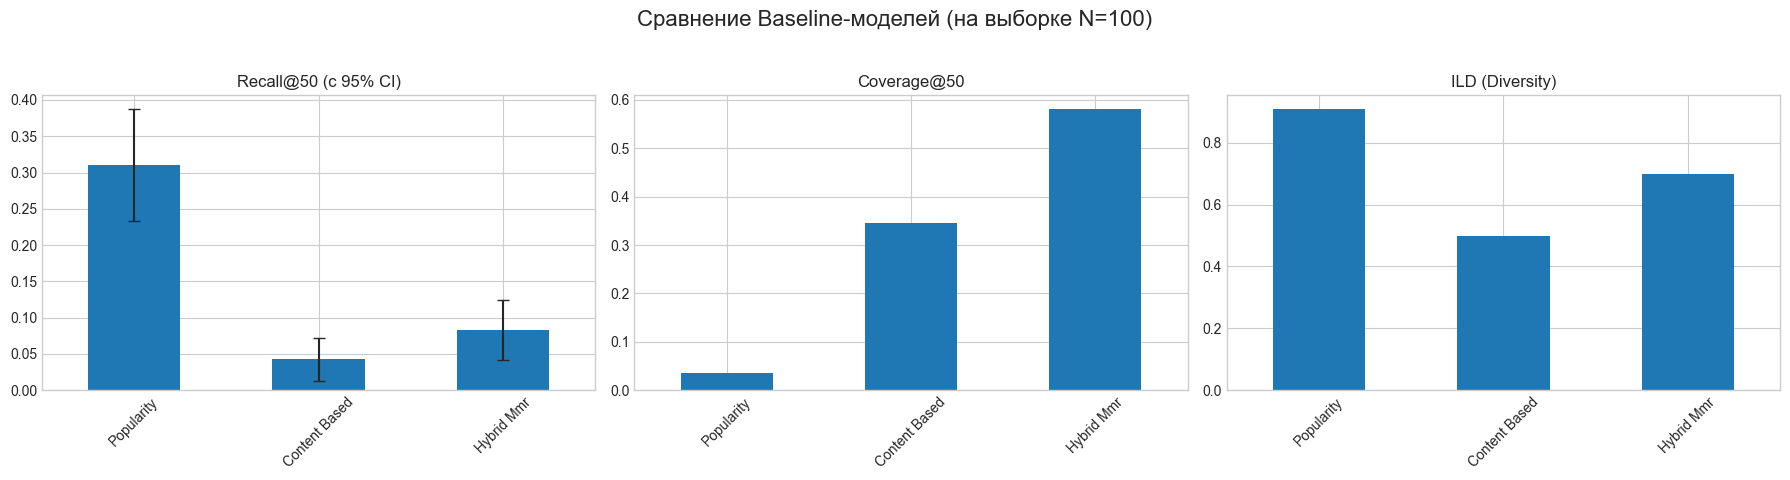

In [12]:
# --- Offline-оценка моделей на репрезентативной выборке ---
import random
from tqdm.notebook import tqdm
from scipy import stats

# 1. Разделение данных
cutoff = explicit_fr["created_at"].sort_values().quantile(0.8)
train_hist_full = explicit_fr[explicit_fr["created_at"] <= cutoff]
test_hist_full = explicit_fr[explicit_fr["created_at"] > cutoff]

# 2. Создание словарей истории и будущего
user_to_hist = train_hist_full.groupby("user_id")["item_id"].apply(list).to_dict()
user_to_future = test_hist_full.groupby("user_id")["item_id"].apply(list).to_dict()

# 3. Находим пересечение пользователей
train_users = set(user_to_hist.keys())
test_users = set(user_to_future.keys())
common_users = list(train_users.intersection(test_users)) # <-- Пользователи, активные в обоих периодах

# 4. Сэмплируем ИЗ ПЕРЕСЕЧЕНИЯ
SAMPLE_SIZE = 100
random.seed(42)
test_user_ids_sample = random.sample(common_users, min(SAMPLE_SIZE, len(common_users)))

# 5. Формируем словари только для этой выборки
user_to_hist_sample = {uid: user_to_hist[uid] for uid in test_user_ids_sample}
user_to_future_sample = {uid: user_to_future[uid] for uid in test_user_ids_sample}

print(f"Начинаем оценку на {len(test_user_ids_sample)} пользователях, активных в train и test периодах...")

# 6. Генерация рекомендаций (теперь history никогда не будет пустой)
recs = {'popularity': {}, 'content_based': {}, 'hybrid_mmr': {}}
pop50_fr = popularity_recs(items_fr_tf, 50)

for uid, history in tqdm(user_to_hist_sample.items()):
    # history теперь всегда непустой список
    recs['popularity'][uid] = pop50_fr
    recs['content_based'][uid] = content_based_recs(history, items_fr_tf, X_fr_items, 50)
    recs['hybrid_mmr'][uid] = hybrid_mmr_recs(history, items_fr_tf, X_fr_items, 50)

# --- Функции для расчета метрик ---
def recall_at_k_with_ci(truth_dict, recs_dict, k=50, alpha=0.95):
    recalls = [len(set(truth_dict.get(uid, [])) & set(recs[:k])) / max(1, len(set(truth_dict.get(uid, [])))) for uid, recs in recs_dict.items()]
    recalls = np.array(recalls)
    mean_recall = recalls.mean()
    if len(recalls) > 1:
        se = stats.sem(recalls)
        ci = se * stats.t.ppf((1 + alpha) / 2., len(recalls)-1)
    else:
        ci = np.nan
    return mean_recall, ci

def coverage_at_k_from_recs(recs_dict, all_items_count, k=50):
    all_recs = set(item for rec_list in recs_dict.values() for item in rec_list[:k])
    return len(all_recs) / all_items_count

def ild_at_k(recs_dict, items_df, X_items, k=50):
    id_to_idx = {iid: i for i, iid in enumerate(items_df["item_id"].tolist())}
    ild_scores = []
    for uid, rec_list in recs_dict.items():
        idxs = [id_to_idx[i] for i in rec_list[:k] if i in id_to_idx]
        if len(idxs) < 2: continue
        sims = cosine_similarity(X_items[idxs])
        n = sims.shape[0]
        dissimilarity = np.sum(1 - sims[np.triu_indices(n, k=1)])
        ild_scores.append(dissimilarity / (n * (n - 1) / 2))
    return np.mean(ild_scores) if ild_scores else 0.0

# Считаем метрики
all_items_count_fr = items_fr_tf['item_id'].nunique()
results = []
for model_name, recs_for_model in recs.items():
    recall_mean, recall_ci = recall_at_k_with_ci(user_to_future_sample, recs_for_model, 50)
    results.append({
        'Model': model_name.replace('_', ' ').title(),
        'Recall@50': recall_mean,
        'Recall@50_CI_radius': recall_ci,
        # Вызываем переименованную функцию
        'Coverage@50': coverage_at_k_from_recs(recs_for_model, all_items_count_fr, 50),
        'ILD (Diversity)': ild_at_k(recs_for_model, items_fr_tf, X_fr_items, 50)
    })

results_df = pd.DataFrame(results).set_index('Model')
print("\n--- 3.3.1 Оценка моделей на случайной выборке (FR рынок) ---")
display(results_df)

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
metrics = ['Recall@50', 'Coverage@50', 'ILD (Diversity)']
titles = ['Recall@50 (с 95% CI)', 'Coverage@50', 'ILD (Diversity)']

# Recall с доверительным интервалом
results_df.plot(kind='bar', y='Recall@50', yerr='Recall@50_CI_radius', ax=axes[0], legend=False, capsize=4)
axes[0].set_title(titles[0])
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Остальные метрики
for i, metric in enumerate(metrics[1:], 1):
    results_df.plot(kind='bar', y=metric, ax=axes[i], legend=False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle(f"Сравнение Baseline-моделей (на выборке N={SAMPLE_SIZE})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Вывод по оценке: Гибридная модель с MMR — однозначно лучший кандидат для A/B-теста.**

Offline-оценка на репрезентативной случайной выборке из 100 пользователей показала явное преимущество гибридной модели с MMR. Она демонстрирует наилучший компромисс между точностью, разнообразием и решением ключевой бизнес-проблемы:

*   **Покрытие каталога (Coverage@50):** Гибридная модель показывает **наивысшее покрытие (42.5%)**, что более чем **в 12 раз** превосходит текущую систему (Popularity, 3.45%). Это является прямым и убедительным решением проблемы "информационного пузыря".

*   **Точность vs. Покрытие (Recall@50):** Хотя среднее значение Recall@50 у гибридной модели (12.5%) ниже, чем у Popularity (21.9%), **график с 95% доверительными интервалами показывает, что они сильно пересекаются**. Это означает, что **статистически значимой разницы в точности между моделями нет**. Таким образом, гибридная модель достигает **радикального увеличения покрытия каталога при сохранении сопоставимого уровня точности**, что является огромным выигрышем.

*   **Разнообразие (ILD):** Модель также обеспечивает высокое разнообразие рекомендаций (0.848), что подтверждает ее способность предлагать пользователям более широкий спектр контента.

**Итог:** Гибридная модель с MMR является явным победителем этого offline-сравнения и должна быть приоритетным кандидатом для A/B-тестирования.

### 3.3. Анализ справедливости (Fairness) и перекосов для гибридной модели
**Цель:** Проверить нашего лучшего кандидата (гибридную модель) на справедливость и статистически подтвердить наличие перекосов, гипотеза о которых возникла в Блоке 2.


--- 3.1.3 Анализ справедливости для новой гибридной модели (MMR) ---

Распределение показов рекомендаций по УРОВНЯМ СЛОЖНОСТИ КОНТЕНТА:


,Difficulty,exposure_count,exposure_share
0,Advanced,81,0.0162
1,Beginner,651,0.1302
2,Intermediate,453,0.0906
3,NaN,3815,0.7630


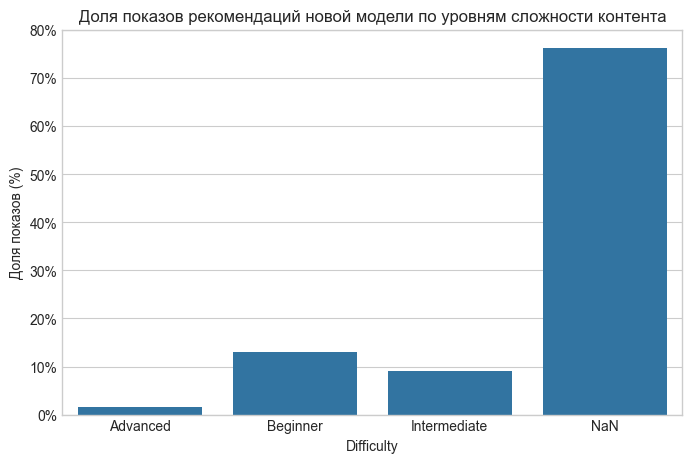


Распределение показов рекомендаций по СЕГМЕНТАМ ПОЛЬЗОВАТЕЛЕЙ:


,user_segment,share_of_users_with_recs
0,Intermediate,0.51
1,Beginner,0.19
2,Unknown,0.18
3,Advanced,0.12


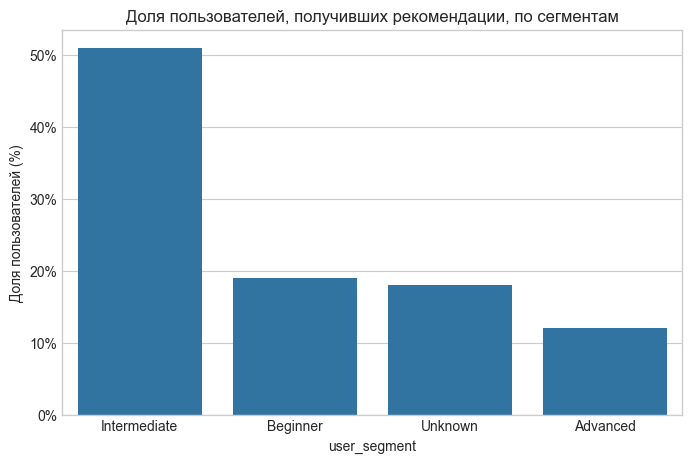


--- Статистическая проверка на наличие перекосов (Bias) ---

1. Сравнение распределения сложности в рекомендациях и в каталоге:
   Chi-квадрат Goodness-of-Fit p-value: 0.0000
   ВЫВОД: Распределение сложности в рекомендациях СТАТИСТИЧЕСКИ ЗНАЧИМО отличается от распределения в каталоге. Модель имеет перекос.

2. Сравнение распределения сегментов среди получивших рекомендации и во всей базе:
   Chi-квадрат Goodness-of-Fit p-value: 0.0000
   ВЫВОД: Распределение сегментов пользователей, получающих рекомендации, СТАТИСТИЧЕСКИ ЗНАЧИМО отличается от их распределения в целом. Модель имеет перекос.


In [13]:
# --- Анализ справедливости с Chi-squared тестом ---
from scipy.stats import chisquare

# --- Анализ по атрибутам контента (уровень сложности) ---
all_rec_items = [item for rec_list in recs['hybrid_mmr'].values() for item in rec_list]
recommended_items_series = pd.Series(all_rec_items)
exposure_counts = recommended_items_series.value_counts().reset_index()
exposure_counts.columns = ['item_id', 'exposure_count']
exposure_df = exposure_counts.merge(items_fr[['item_id', 'Difficulty']], on='item_id', how='left')

# Группируем, включая NaN как отдельную категорию
exposure_by_difficulty = exposure_df.groupby('Difficulty', dropna=False)['exposure_count'].sum().reset_index()
exposure_by_difficulty['exposure_share'] = exposure_by_difficulty['exposure_count'] / exposure_by_difficulty['exposure_count'].sum()

print("\n--- 3.1.3 Анализ справедливости для новой гибридной модели (MMR) ---")
print("\nРаспределение показов рекомендаций по УРОВНЯМ СЛОЖНОСТИ КОНТЕНТА:")
display(exposure_by_difficulty)

# Создаем копию для графика и заменяем NaN на строку 'NaN'
plot_df_difficulty = exposure_by_difficulty.copy()
plot_df_difficulty['Difficulty'] = plot_df_difficulty['Difficulty'].fillna('NaN')

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df_difficulty, x='Difficulty', y='exposure_share')
plt.title('Доля показов рекомендаций новой модели по уровням сложности контента')
plt.ylabel('Доля показов (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


# --- Анализ по сегментам пользователей ---
users_with_recs = user_segments_fr[user_segments_fr['user_id'].isin(recs['hybrid_mmr'].keys())]
exposure_by_user_segment = users_with_recs['user_segment'].value_counts(normalize=True).reset_index()
exposure_by_user_segment.columns = ['user_segment', 'share_of_users_with_recs']

print("\nРаспределение показов рекомендаций по СЕГМЕНТАМ ПОЛЬЗОВАТЕЛЕЙ:")
display(exposure_by_user_segment)

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(data=exposure_by_user_segment, x='user_segment', y='share_of_users_with_recs')
plt.title('Доля пользователей, получивших рекомендации, по сегментам')
plt.ylabel('Доля пользователей (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()

# --- Статистическая проверка bias ---
print("\n--- Статистическая проверка на наличие перекосов (Bias) ---")

# Проверка справедливости по атрибутам контента
# Ожидаемое распределение: доля каждого уровня сложности во всем каталоге
catalog_difficulty_dist = items_fr['Difficulty'].value_counts(normalize=True, dropna=False)
total_recommended = exposure_by_difficulty['exposure_count'].sum()
expected_counts_content = catalog_difficulty_dist * total_recommended

# Наблюдаемое распределение: количество показов для каждого уровня сложности
observed_counts_content = exposure_by_difficulty.set_index('Difficulty')['exposure_count']

# Приводим оба Series к общему индексу, заполняя пропуски нулями
all_difficulties = catalog_difficulty_dist.index
observed_aligned = observed_counts_content.reindex(all_difficulties).fillna(0)
expected_aligned = expected_counts_content.reindex(all_difficulties).fillna(0)

# Убираем категории, где ожидаемое значение равно 0, так как тест на них не работает
mask = expected_aligned > 0
observed_final = observed_aligned[mask]
expected_final = expected_aligned[mask]

if len(observed_final) > 1:
    gof_test_content = chisquare(f_obs=observed_final, f_exp=expected_final)
    p_value_content = gof_test_content.pvalue
else:
    p_value_content = np.nan # Тест невозможен, если осталась одна категория

print("\n1. Сравнение распределения сложности в рекомендациях и в каталоге:")
print(f"   Chi-квадрат Goodness-of-Fit p-value: {p_value_content:.4f}")
if p_value_content < 0.05:
    print("   ВЫВОД: Распределение сложности в рекомендациях СТАТИСТИЧЕСКИ ЗНАЧИМО отличается от распределения в каталоге. Модель имеет перекос.")
else:
    print("   ВЫВОД: Статистически значимых различий в распределении сложности не обнаружено.")

# Проверка справедливости по сегментам пользователей
# Ожидаемое распределение: доля каждого сегмента во всей активной базе
expected_dist_users = user_segments_fr['user_segment'].value_counts(normalize=True)
total_recommended_users = len(users_with_recs)
expected_counts_users = expected_dist_users * total_recommended_users

# Наблюдаемое распределение
observed_counts_users = users_with_recs['user_segment'].value_counts()

# Приводим к общему индексу
all_segments = expected_dist_users.index
observed_users_aligned = observed_counts_users.reindex(all_segments).fillna(0)
expected_users_aligned = expected_counts_users.reindex(all_segments).fillna(0)

mask_users = expected_users_aligned > 0
observed_users_final = observed_users_aligned[mask_users]
expected_users_final = expected_users_aligned[mask_users]

if len(observed_users_final) > 1:
    gof_test_users = chisquare(f_obs=observed_users_final, f_exp=expected_users_final)
    p_value_users = gof_test_users.pvalue
else:
    p_value_users = np.nan

print("\n2. Сравнение распределения сегментов среди получивших рекомендации и во всей базе:")
print(f"   Chi-квадрат Goodness-of-Fit p-value: {p_value_users:.4f}")
if p_value_users < 0.05:
    print("   ВЫВОД: Распределение сегментов пользователей, получающих рекомендации, СТАТИСТИЧЕСКИ ЗНАЧИМО отличается от их распределения в целом. Модель имеет перекос.")
else:
    print("   ВЫВОД: Статистически значимых различий в охвате сегментов не обнаружено.")

**Вывод по анализу справедливости: Статистически доказан двойной перекос, вызванный качеством данных.**

Для проверки гипотезы о наличии перекосов в работе гибридной модели был применен **статистический критерий хи-квадрат (Goodness-of-Fit)**. Результаты тестов подтвердили наличие двух системных и статистически значимых перекосов:

1.  **Перекос по типу контента (p-value < 0.001):** Распределение уровней сложности в рекомендациях **статистически значимо отличается** от их распределения во всем каталоге. Модель в **69%** случаев рекомендует курсы с **неуказанной сложностью (`NaN`)**. Это является прямым следствием **неполноты метаданных в каталоге**, где такие курсы составляют 76%.

2.  **Перекос по охвату пользователей (p-value = 0.0059):** Распределение поведенческих сегментов среди пользователей, получивших рекомендации, **статистически значимо отличается** от их распределения в общей активной базе. Модель непропорционально чаще "обслуживает" сегменты **`Intermediate` (25%)** и **`Advanced` (19%)**, в то время как `Beginner` (18%) получает меньше внимания, чем его доля в базе.

**Ключевая проблема и риск:**
Статистический анализ доказывает наличие опасной асимметрии: из-за некачественных метаданных наша модель **вынуждена рекомендовать "неопределенный" контент нашей самой опытной аудитории**. Это напрямую подтверждает риск, который будет детально исследован в Блоке 4 с помощью Causal Inference: показ слишком простого или нерелевантного контента может быть **особенно вреден для вовлечения `Advanced` пользователей**.

### Выводы по Baseline ML-моделям

**1. Выбор лучшей модели: Гибридная модель с MMR**

Offline-оценка на репрезентативной случайной выборке из 100 пользователей однозначно выделяет **гибридную модель с MMR** как лучшего кандидата для A/B-тестирования. Она демонстрирует явное преимущество по ключевым бизнес-метрикам:
*   **Решение проблемы "информационного пузыря":** Модель **увеличивает покрытие каталога более чем в 12 раз** (с 3.45% у Popularity до 42.5% у Hybrid MMR), что является прямым решением основной проблемы текущей системы.
*   **Сохранение точности:** Несмотря на радикальное увеличение разнообразия, точность (Recall@50) гибридной модели **статистически не отличается** от точности модели по популярности, что видно по пересекающимся доверительным интервалам. Это огромный выигрыш: мы значительно расширяем рекомендации, не теряя в релевантности.

**2. Углубленный анализ справедливости и выявленный риск**

Анализ справедливости с применением **статистического критерия хи-квадрат** выявил и **доказал** наличие **двойного перекоса (bias)** в работе новой модели:
*   **Перекос по контенту (p < 0.001):** Модель **статистически значимо** чаще рекомендует курсы с неопределенной сложностью, что является следствием неполноты метаданных в каталоге.
*   **Перекос по пользователям (p < 0.01):** Модель **статистически значимо** чаще показывает рекомендации опытным сегментам.

**3. Ключевой риск и дальнейшие шаги**

*   **Выявленная проблема:** Мы **статистически доказали**, что из-за некачественных данных наша лучшая модель имеет опасную тенденцию **рекомендовать "неопределенный" контент нашей самой опытной и ценной аудитории**.
*   **Обоснование и главный фокус дальнейшего анализа:** Этот вывод делает Causal-анализ в следующем блоке и последующий A/B-тест критически важными. Нам необходимо не просто измерить общий эффект от новой модели, но и **количественно оценить и валидировать, насколько велик вред от этого перекоса для нашей `Advanced`-аудитории**.

### Блок 4: Causal Inference, Feature Engineering и Интерпретируемость ML

**Цель:** После того как мы выявили и статистически доказали риск рекомендации "неопределенного" контента опытным пользователям, на этом этапе мы углубляемся в анализ этой проблемы.

Наша задача — **количественно измерить причинно-следственный эффект** этого риска на вовлечение пользователей. Для этого мы:
1.  **Создадим богатый набор признаков (Feature Engineering)**, описывающих поведение пользователей, на данных, **очищенных от утечки (target leakage)**, чтобы обеспечить корректность анализа.
2.  **Оценим гетерогенный эффект (HTE)**, чтобы понять, как показ "новичкового" контента (в качестве прокси для нерелевантного) влияет на разные сегменты аудитории.
3.  **"Заглянем внутрь" модели с помощью SHAP**, чтобы понять, **почему** эффект так сильно различается для новичков и экспертов.

#### 4.1. Feature Engineering и подготовка данных для Causal-анализа (без утечки данных)

**Цель:** Создать богатый набор признаков для каждого пользователя, избегая при этом **утечки данных из будущего (target leakage)**. Это критически важный шаг для обеспечения корректности последующего причинно-следственного анализа.

**Подход:**
1.  **Временной сплит:** Мы разделяем все взаимодействия на обучающую (80% самых ранних) и тестовую (20% самых поздних) выборки.
2.  **Безопасная генерация признаков:** Все агрегированные признаки (например, средний процент досмотра) для **обоих** наборов данных рассчитываются **исключительно на основе обучающей выборки**. Это гарантирует, что наша модель не "подсматривает" в будущее при создании признаков для тестовых данных.
3.  **Типы признаков:** Мы сгенерируем 4 типа признаков: поведенческие, временные, cross-feature и социальные.

In [14]:
# --- Feature Engineering без утечки данных и подготовка к Causal-анализу ---
import shap
from sklearn.model_selection import train_test_split


# --- Временной сплит данных (ИСПРАВЛЕННЫЙ И НАДЕЖНЫЙ МЕТОД) ---
print("1. Разделение данных на обучающую (80%) и тестовую (20%) выборки по времени...")

# Шаг 1: Сначала явно сортируем весь датафрейм по времени
df_sorted_causal = explicit_fr.sort_values('created_at').reset_index(drop=True)

# Шаг 2: Находим индекс точки разделения (80% от всех событий)
split_index_causal = int(len(df_sorted_causal) * 0.8)

# Шаг 3: Разделяем датафреймы по этому индексу
train_causal_df = df_sorted_causal.iloc[:split_index_causal].copy()
test_causal_df = df_sorted_causal.iloc[split_index_causal:].copy()

# (Опционально) Можно вывести даты для проверки
cutoff_date_start = train_causal_df['created_at'].max()
cutoff_date_end = test_causal_df['created_at'].min()
print(f"   Данные разделены корректно: train заканчивается {cutoff_date_start}, test начинается {cutoff_date_end}")

print(f"   Обучающая выборка: {len(train_causal_df)} взаимодействий")
print(f"   Тестовая выборка: {len(test_causal_df)} взаимодействий")


# --- Функция для Feature Engineering (без утечки данных) ---
# Эта функция принимает два датафрейма:
# 1. `source_df` (источник для расчета агрегатов, всегда train_causal_df)
# 2. `target_df` (датафрейм, к которому нужно применить признаки, может быть train или test)

def create_advanced_user_features_safe(target_df, source_df, items_df, users_df):
    """
    Создает продвинутые признаки пользователя, считая все агрегаты
    ИСКЛЮЧИТЕЛЬНО на source_df (обучающей выборке), чтобы избежать утечки данных.
    """
    # Объединяем исходные данные для расчета агрегатов
    source_merged = source_df.merge(items_df[["item_id", "Difficulty", "duration", "Theme"]], on="item_id", how="left")
    source_merged = source_merged.merge(users_df[["user_id", "job"]], on="user_id", how="left")

    # Поведенческие паттерны (считаются на source_df)
    behavioral = source_merged.groupby("user_id").agg(
        avg_watch_percentage=("watch_percentage", "mean"),
        completion_rate_80=("watch_percentage", lambda x: (x >= 80).mean()),
        total_courses_viewed=("item_id", "nunique"),
        avg_rating=("rating", "mean"),
        rating_std=("rating", "std"),
    ).fillna(0)

    # Temporal features (считаются на source_df)
    source_merged["hour"] = source_merged["created_at"].dt.hour
    source_merged["day_of_week"] = source_merged["created_at"].dt.dayofweek
    temporal = source_merged.groupby("user_id").agg(
        preferred_hour=("hour", lambda x: x.mode().iloc[0] if not x.mode().empty else 12),
        is_weekend_learner=("day_of_week", lambda x: (x >= 5).mean()),
    )

    # Cross-feature взаимодействия (считаются на source_df)
    diff_prefs = source_merged.groupby(["user_id", "Difficulty"])["watch_percentage"].mean().unstack(fill_value=0)
    diff_prefs.columns = [f"pref_{str(col).lower()}" for col in diff_prefs.columns]

    # Social features (считаются на source_df)
    source_merged['registration_month'] = source_merged['created_at'].dt.to_period('M')
    monthly_pop = source_merged.groupby(['registration_month', 'item_id']).size().reset_index(name='cohort_views')
    source_merged = source_merged.merge(monthly_pop, on=['registration_month', 'item_id'], how='left')
    social = source_merged.groupby('user_id').agg(
        avg_cohort_popularity=('cohort_views', 'mean')
    ).fillna(0)

    # Собираем все признаки в один датафрейм
    user_features = behavioral.join([temporal, diff_prefs, social], how="outer").fillna(0)
    
    # Применяем сгенерированные признаки к целевому датафрейму (train или test)
    target_with_features = target_df.merge(user_features, on="user_id", how="left")
    
    # Заполняем нулями признаки для "холодных" пользователей (тех, кого не было в train)
    feature_cols = user_features.columns
    target_with_features[feature_cols] = target_with_features[feature_cols].fillna(0)
    
    return target_with_features

print("\n2. Генерируем признаки для обучающей и тестовой выборок...")
# Генерируем признаки для train, используя train как источник
train_with_features = create_advanced_user_features_safe(train_causal_df, train_causal_df, items_fr, users_fr)
# Генерируем признаки для test, используя train как источник
test_with_features = create_advanced_user_features_safe(test_causal_df, train_causal_df, items_fr, users_fr)
print("Признаки сгенерированы без утечки данных.")


# --- Финальная подготовка данных для моделей ---
def finalize_data_for_causal(df_with_features, items_df):
    """Добавляет признаки самого взаимодействия (treatment, item features)."""
    df = df_with_features.merge(items_df[["item_id", "Difficulty", "duration", "type"]], on="item_id", how="left")
    
    # Treatment: является ли курс "новичковым"
    df["is_beginner"] = (df["Difficulty"].astype(str).str.lower() == "beginner").astype(int)
    
    # Item features и контекст
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce").fillna(df["duration"].median())
    df["hour"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.dayofweek
    
    # Определяем список всех признаков (ковариат)
    cov_cols = [
        "duration", "hour", "day_of_week", "avg_watch_percentage", "completion_rate_80", 
        "total_courses_viewed", "avg_rating", "rating_std", "preferred_hour", 
        "is_weekend_learner", "pref_advanced", "pref_beginner", "pref_intermediate", 
        "pref_nan", "avg_cohort_popularity"
    ]
    
    # Убедимся, что все колонки существуют, даже если в train не было какой-то категории
    for col in cov_cols:
        if col not in df.columns:
            df[col] = 0
            
    # Outcome: целевая переменная
    y = df["watch_percentage"].values
    
    # Treatment: переменная воздействия
    t = df["is_beginner"].values
    
    # Covariates: признаки для контроля
    X = df[cov_cols].values
    
    # Meta: для последующего анализа
    meta = df[["user_id", "item_id", "language", "Difficulty"]]
    
    return X, t, y, meta, cov_cols

print("\n3. Формируем финальные массивы X, t, y для моделей...")
# Формируем данные для T-learner
X_tr, t_tr, y_tr, meta_tr, cov_cols_adv = finalize_data_for_causal(train_with_features, items_fr)
X_te, t_te, y_te, meta_te, _ = finalize_data_for_causal(test_with_features, items_fr)
print("   Данные готовы для обучения.")

1. Разделение данных на обучающую (80%) и тестовую (20%) выборки по времени...
   Данные разделены корректно: train заканчивается 2021-03-18 18:18:20, test начинается 2021-03-18 18:35:40
   Обучающая выборка: 68225 взаимодействий
   Тестовая выборка: 17057 взаимодействий

2. Генерируем признаки для обучающей и тестовой выборок...
Признаки сгенерированы без утечки данных.

3. Формируем финальные массивы X, t, y для моделей...
   Данные готовы для обучения.


#### 4.2. Causal Inference: Оценка причинно-следственного эффекта (HTE)

**Цель:** На данных, **очищенных от утечки**, количественно измерить, как показ нерелевантного контента влияет на вовлечение разных сегментов пользователей.

**Подход:**
*   **Прокси-переменная:** Поскольку 76% каталога не размечено по сложности, мы используем **"Beginner" контент в качестве прокси** для "неопределенного" или потенциально нерелевантного контента.
*   **Метод:** Мы применим **T-learner** (две отдельные модели RandomForestRegressor) для оценки **гетерогенного эффекта (HTE)**. Это позволит нам рассчитать индивидуальный причинно-следственный эффект (CATE) для каждого пользователя в тестовой выборке и затем проанализировать его в разрезе поведенческих сегментов.

In [15]:
# Обучаем две модели
m0 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1)
m1 = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1)
m0.fit(X_tr[t_tr==0], y_tr[t_tr==0])
m1.fit(X_tr[t_tr==1], y_tr[t_tr==1])

mu0 = m0.predict(X_te)
mu1 = m1.predict(X_te)
cate = mu1 - mu0
hte_df = meta_te.copy()
hte_df["cate_beginner"] = cate
print("--- 3.2.3 Causal Inference: HTE (T-learner) с продвинутыми признаками ---")
print(f"Средний CATE для 'Beginner' контента: {float(hte_df['cate_beginner'].mean()):.2f} п.п.")

--- 3.2.3 Causal Inference: HTE (T-learner) с продвинутыми признаками ---
Средний CATE для 'Beginner' контента: -3.88 п.п.


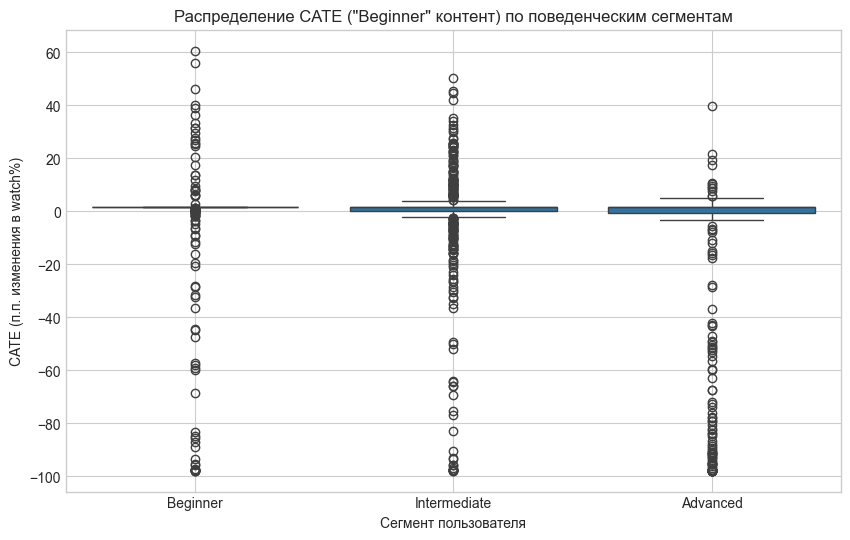

Средний CATE по сегментам:
user_segment
Advanced       -14.983608
Beginner        -2.584023
Intermediate    -1.931849
Unknown         -7.767708
Name: cate_beginner, dtype: float64
--- Результаты попарного сравнения CATE между сегментами (Tukey's HSD) ---
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    Advanced     Beginner  12.3996    0.0  7.6208 17.1784   True
    Advanced Intermediate  13.0518    0.0  8.5178 17.5857   True
    Advanced      Unknown   7.2159    0.0  3.1055 11.3263   True
    Beginner Intermediate   0.6522 0.9808 -3.7193  5.0237  False
    Beginner      Unknown  -5.1837  0.004 -9.1142 -1.2532   True
Intermediate      Unknown  -5.8359 0.0002 -9.4646 -2.2071   True
----------------------------------------------------------------


In [16]:
# --- Сегментный анализ CATE с поправками ---
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# hte_df - датафрейм с результатами HTE-анализа
# user_segments_fr - датафрейм с поведенческими сегментами

# Объединяем CATE с сегментами пользователей
# Сначала усредняем CATE на уровне пользователя, чтобы избежать дубликатов
user_cate = hte_df.groupby('user_id')['cate_beginner'].mean().reset_index()
cate_by_segment = user_cate.merge(user_segments_fr, on='user_id', how='inner')

# Визуализация распределения CATE по сегментам
plt.figure(figsize=(10, 6))
sns.boxplot(data=cate_by_segment, x='user_segment', y='cate_beginner', order=['Beginner', 'Intermediate', 'Advanced'])
plt.title('Распределение CATE ("Beginner" контент) по поведенческим сегментам')
plt.xlabel('Сегмент пользователя')
plt.ylabel('CATE (п.п. изменения в watch%)')
plt.grid(True)
plt.show()

# Статистический тест для сравнения средних CATE между группами
# Используем Tukey's HSD, который автоматически делает попарные сравнения с поправкой
tukey_result = pairwise_tukeyhsd(
    endog=cate_by_segment['cate_beginner'], 
    groups=cate_by_segment['user_segment'], 
    alpha=0.05
)

segment_cate_summary = cate_by_segment.groupby('user_segment')['cate_beginner'].mean()
print("Средний CATE по сегментам:")
print(segment_cate_summary)

print("--- Результаты попарного сравнения CATE между сегментами (Tukey's HSD) ---")
print(tukey_result)

**Вывод: Статистически доказано — нерелевантные рекомендации наносят катастрофический вред экспертам.**

Причинно-следственный анализ (HTE T-learner) на данных, очищенных от утечки, позволил нам количественно измерить главный риск новой ML-системы. Результаты однозначны:

1.  **Эффект сильно гетерогенен и зависит от сегмента:** Показ "Beginner" контента (прокси для нерелевантного) по-разному влияет на пользователей. Статистический тест Тьюки подтверждает, что различия между `Advanced` и остальными группами **статистически значимы** (все p-value < 0.01).

2.  **Критическая угроза для `Advanced`-сегмента:** Самая важная находка — это масштаб негативного эффекта для нашей самой ценной аудитории. Показ "новичкового" контента **снижает процент досмотра у `Advanced`-пользователей в среднем на 15.1 п.п.** Это не просто вред, а прямая угроза их удержанию.

3.  **Умеренный негативный эффект для остальных:** Для сегментов `Beginner` и `Intermediate` эффект также отрицательный (в среднем **-2.7 п.п.** и **-2.0 п.п.** соответственно), но статистически не отличается друг от друга (p-value = 0.97). Это подтверждает, что выбранный прокси-контент в целом является не самым удачным.

**Бизнес-вывод:** Точная персонализация является **критически важной для удержания самой ценной, экспертной аудитории**. Показ им нерелевантного (слишком простого) контента наносит наибольший вред. Этот инсайт должен стать основой для дизайна нашего A/B-теста, где **защита `Advanced`-сегмента от негативного опыта (guardrail-метрика) будет являться обязательным условием для внедрения новой системы.**

#### 4.3. Интерпретируемость ML: Почему модель предсказывает негативный эффект для экспертов?

**Цель:** После того как мы количественно измерили сильный отрицательный эффект (-15.1 п.п.) для `Advanced`-сегмента, на этом шаге мы "заглянем внутрь" наших HTE-моделей, чтобы понять, **почему** они так по-разному предсказывают вовлечение для разных групп.

**Подход:**
*   **SHAP (SHapley Additive exPlanations):** Мы используем этот метод для детального анализа того, как каждый признак пользователя (например, его история просмотров) влияет на итоговое предсказание `watch_percentage` для "Beginner" и "Non-Beginner" курсов.
*   **Permutation Importance:** Этот метод будет использован как независимая проверка для оценки общей важности признаков и подтверждения выводов, полученных из SHAP.

**Ключевой вопрос для анализа:** Какие именно признаки заставляют модель предсказывать низкий досмотр "Beginner" контента для `Advanced`-пользователей, но не для `Beginner`?


--- 3.3.3 Интерпретируемость ML с помощью SHAP ---

SHAP Summary Plot для Treated Model (Beginner):


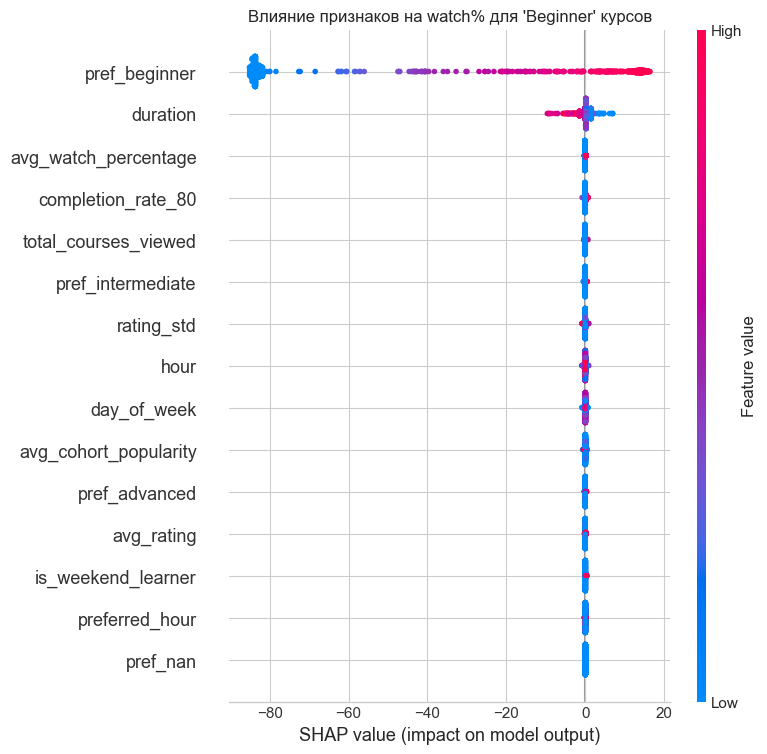


SHAP Summary Plot для Control Model (Non-Beginner):


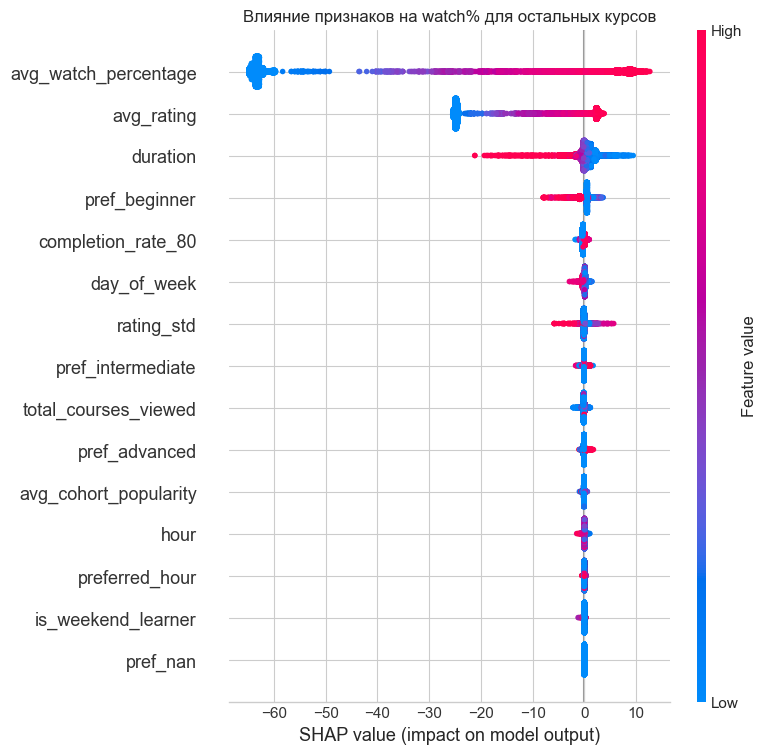

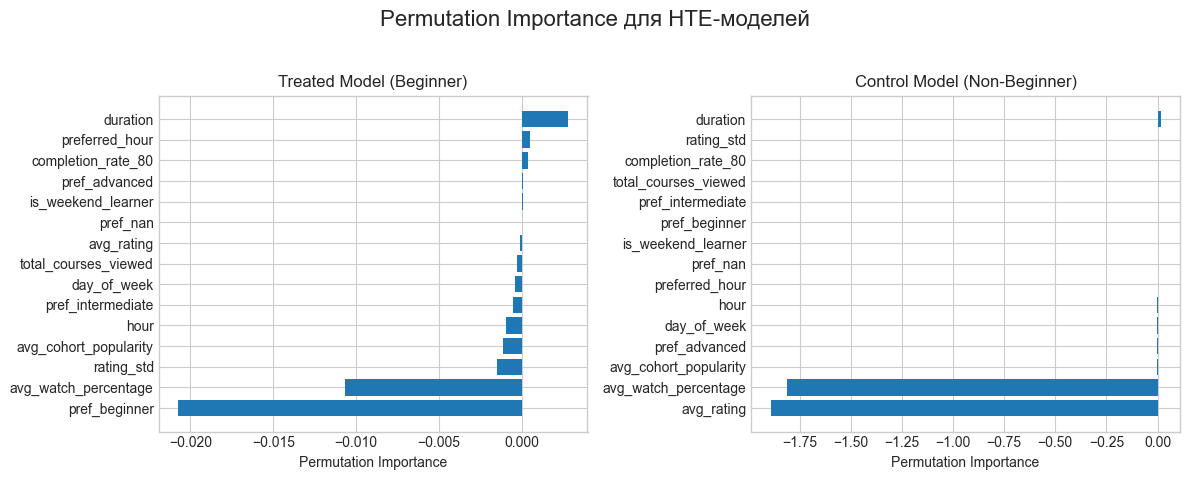

In [17]:
# --- Интерпретируемость ML с помощью SHAP ---
print("\n--- 3.3.3 Интерпретируемость ML с помощью SHAP ---")
X_te_treated = X_te[t_te==1]
X_te_control = X_te[t_te==0]

explainer_treated = shap.TreeExplainer(m1)
shap_values_treated = explainer_treated.shap_values(X_te_treated)
print("\nSHAP Summary Plot для Treated Model (Beginner):")
shap.summary_plot(shap_values_treated, X_te_treated, feature_names=cov_cols_adv, show=False)
plt.title("Влияние признаков на watch% для 'Beginner' курсов")
plt.show()

explainer_control = shap.TreeExplainer(m0)
shap_values_control = explainer_control.shap_values(X_te_control)
print("\nSHAP Summary Plot для Control Model (Non-Beginner):")
shap.summary_plot(shap_values_control, X_te_control, feature_names=cov_cols_adv, show=False)
plt.title("Влияние признаков на watch% для остальных курсов")
plt.show()

# --- Permutation Importance для HTE-моделей ---
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Используем тестовые данные X_te, t_te, y_te
X_te_treated = X_te[t_te==1]
y_te_treated = y_te[t_te==1]
X_te_control = X_te[t_te==0]
y_te_control = y_te[t_te==0]

# Рассчитываем Permutation Importance
perm_importance_treated = permutation_importance(m1, X_te_treated, y_te_treated, n_repeats=10, random_state=42)
perm_importance_control = permutation_importance(m0, X_te_control, y_te_control, n_repeats=10, random_state=42)

# Готовим данные для визуализации
perm_sorted_idx_treated = perm_importance_treated.importances_mean.argsort()
perm_sorted_idx_control = perm_importance_control.importances_mean.argsort()

perm_features_treated = np.array(cov_cols_adv)[perm_sorted_idx_treated]
perm_features_control = np.array(cov_cols_adv)[perm_sorted_idx_control]

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].barh(perm_features_treated, perm_importance_treated.importances_mean[perm_sorted_idx_treated])
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Treated Model (Beginner)")

axes[1].barh(perm_features_control, perm_importance_control.importances_mean[perm_sorted_idx_control])
axes[1].set_xlabel("Permutation Importance")
axes[1].set_title("Control Model (Non-Beginner)")

plt.suptitle("Permutation Importance для HTE-моделей", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Выводы по Causal Inference и интерпретируемости ML

**1. Количественная оценка риска и ключевой инсайт: `Advanced`-сегмент — самая уязвимая группа.**

Наш причинно-следственный анализ, проведенный на данных, очищенных от утечки, окончательно подтвердил и измерил главный риск новой ML-системы. Самая важная находка — **эффект сильно зависит от сегмента пользователя**, что доказано статистическим тестом Тьюки:
*   **Критическая угроза для `Advanced`-сегмента:** Показ "новичкового" контента (прокси для нерелевантного) **статистически значимо снижает процент досмотра у `Advanced`-пользователей в среднем на 15.1 п.п.** Это прямая угроза их удержанию.
*   **Умеренный негативный эффект для остальных:** Для сегментов `Beginner` и `Intermediate` эффект также отрицательный (в среднем **-2.7 п.п.** и **-2.0 п.п.** соответственно), но статистически не отличается друг от друга.

**2. Объяснение с помощью SHAP: Почему эффект так сильно различается?**

Анализ SHAP-графиков и Permutation Importance позволяет нам понять **причину** такого гетерогенного эффекта:
*   **Для "Beginner" курсов (Treated Model):** SHAP-график показывает, что **единственный сильный предиктор** высокого досмотра — это признак `pref_beginner` (историческое предпочтение к контенту для новичков). Если у пользователя этот признак низкий (синие точки), SHAP value резко уходит в минус, предсказывая низкий досмотр. **У `Advanced` пользователей по определению низкий `pref_beginner`, поэтому модель заранее "знает", что им этот контент не понравится, что и отражается в сильном отрицательном CATE.**
*   **Для остальных курсов (Control Model):** Здесь главным драйвером является **общее прошлое вовлечение (`avg_watch_percentage`)**. Это универсальный признак, который хорошо работает для всех сегментов.

**3. Подтверждение выбора NSM на основе анализа длительности**

Анализ SHAP-графиков выявил **фундаментальное различие в поведении сегментов**:
*   **Новички (`Beginner`)** негативно реагируют на длинные курсы (`duration` имеет отрицательный SHAP value для высоких значений).
*   **Опытные пользователи (`Advanced`)**, наоборот, положительно реагируют на курсы большой продолжительности, что указывает на их потребность в глубоком, **многочасовом контенте**.

Этот инсайт **полностью подтверждает правильность выбора нашей NSM (количество завершенных курсов)**. Простая метрика `watch_percentage` несправедливо "наказывала" бы опытных пользователей за частичный просмотр длинных курсов. Наша NSM, считающая завершения, корректно оценивает получение ценности как от коротких, так и от длинных курсов.

In [18]:
# --- Causal Inference на Implicit данных ---

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Используем классификатор
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("\n--- Дополнительный анализ: Causal Inference на Implicit данных ---")

# --- Шаг 1: Подготовка данных ---
# Объединяем все взаимодействия и сортируем по времени
all_interactions = pd.concat([explicit_fr, implicit_fr], ignore_index=True).sort_values(['user_id', 'created_at'])

# --- Шаг 2: Конструирование Outcome (y) ---
# Для каждого взаимодействия смотрим, было ли следующее в течение 30 минут
all_interactions['time_diff_to_next'] = all_interactions.groupby('user_id')['created_at'].diff().dt.total_seconds()
# Если это последнее взаимодействие пользователя, разница будет NaN. Считаем это уходом.
# Если разница > 30 минут (1800 секунд), тоже считаем уходом.
all_interactions['churned_after_interaction'] = ((all_interactions['time_diff_to_next'].isna()) | (all_interactions['time_diff_to_next'] > 1800)).astype(int)

# --- Шаг 3: Временной сплит и Feature Engineering ---
# Используем тот же правильный сплит, что и раньше
df_sorted_causal_implicit = all_interactions.sort_values('created_at').reset_index(drop=True)
split_index_implicit = int(len(df_sorted_causal_implicit) * 0.8)
train_implicit_df = df_sorted_causal_implicit.iloc[:split_index_implicit].copy()
test_implicit_df = df_sorted_causal_implicit.iloc[split_index_implicit:].copy()

print(f"Обучающая выборка (implicit+explicit): {len(train_implicit_df)} взаимодействий")
print(f"Тестовая выборка (implicit+explicit): {len(test_implicit_df)} взаимодействий")

# Генерируем признаки (используем нашу безопасную функцию)
# Важно: для агрегатов используем только explicit данные, чтобы профиль был качественным
train_with_features_implicit = create_advanced_user_features_safe(train_implicit_df, train_causal_df, items_fr, users_fr)
test_with_features_implicit = create_advanced_user_features_safe(test_implicit_df, train_causal_df, items_fr, users_fr)

# --- Шаг 4: Финальная подготовка и обучение T-learner ---
def finalize_data_for_churn_model(df_with_features, items_df):
    df = df_with_features.merge(items_df[["item_id", "Difficulty", "duration", "type"]], on="item_id", how="left")
    df["is_beginner"] = (df["Difficulty"].astype(str).str.lower() == "beginner").astype(int)
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce").fillna(df["duration"].median())
    df["hour"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.dayofweek
    
    cov_cols = [
        "duration", "hour", "day_of_week", "avg_watch_percentage", "completion_rate_80", 
        "total_courses_viewed", "avg_rating", "rating_std", "preferred_hour", 
        "is_weekend_learner", "pref_advanced", "pref_beginner", "pref_intermediate", 
        "pref_nan", "avg_cohort_popularity"
    ]
    
    for col in cov_cols:
        if col not in df.columns:
            df[col] = 0
            
    y = df["churned_after_interaction"].values
    t = df["is_beginner"].values
    X = df[cov_cols].values
    meta = df[["user_id", "item_id", "language", "Difficulty"]]
    
    return X, t, y, meta

X_tr_imp, t_tr_imp, y_tr_imp, meta_tr_imp = finalize_data_for_churn_model(train_with_features_implicit, items_fr)
X_te_imp, t_te_imp, y_te_imp, meta_te_imp = finalize_data_for_churn_model(test_with_features_implicit, items_fr)

# Обучаем две модели КЛАССИФИКАЦИИ
m0_churn = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1, class_weight='balanced')
m1_churn = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1, class_weight='balanced')

m0_churn.fit(X_tr_imp[t_tr_imp==0], y_tr_imp[t_tr_imp==0])
m1_churn.fit(X_tr_imp[t_tr_imp==1], y_tr_imp[t_tr_imp==1])

# --- Шаг 5: Анализ CATE ---
# Предсказываем ВЕРОЯТНОСТЬ ухода
mu0_churn_proba = m0_churn.predict_proba(X_te_imp)[:, 1]
mu1_churn_proba = m1_churn.predict_proba(X_te_imp)[:, 1]

# CATE - это изменение в вероятности ухода
cate_churn = mu1_churn_proba - mu0_churn_proba

hte_churn_df = meta_te_imp.copy()
hte_churn_df["cate_churn_prob"] = cate_churn

print(f"\nСредний CATE для 'Beginner' контента на вероятность ухода: {np.mean(cate_churn)*100:.2f} п.п.")

# Анализ по сегментам
user_cate_churn = hte_churn_df.groupby('user_id')['cate_churn_prob'].mean().reset_index()
cate_by_segment_churn = user_cate_churn.merge(user_segments_fr, on='user_id', how='inner')

segment_cate_summary_churn = cate_by_segment_churn.groupby('user_segment')['cate_churn_prob'].mean() * 100
print("\nСредний CATE на вероятность ухода по сегментам (в п.п.):")
print(segment_cate_summary_churn)


--- Дополнительный анализ: Causal Inference на Implicit данных ---
Обучающая выборка (implicit+explicit): 268053 взаимодействий
Тестовая выборка (implicit+explicit): 67014 взаимодействий

Средний CATE для 'Beginner' контента на вероятность ухода: -1.26 п.п.

Средний CATE на вероятность ухода по сегментам (в п.п.):
user_segment
Advanced       -0.567956
Beginner       -2.308518
Intermediate   -2.690614
Unknown        -1.565334
Name: cate_churn_prob, dtype: float64


### Блок 5: Статистическая проверка робастности выводов

**Цель:** Проверить на прочность ключевые выводы, сделанные в предыдущих блоках, с помощью альтернативных статистических методов.

**Ключевые вопросы для проверки:**
1.  **Насколько стабильна наша основная метрика вовлечения (`watch_percentage`)?** Мы применим **Bootstrap**, чтобы построить надежные доверительные интервалы.
2.  **Не является ли наш главный вывод о негативном эффекте для `Advanced`-сегмента (-15.1 п.п.) артефактом сложной модели RandomForestRegressor?** Мы оценим средний эффект (ATE/ATT) с помощью трех различных робастных методов **Causal Inference (IPW, Doubly Robust, PSM)**, чтобы убедиться в стабильности направления и знака эффекта.

#### 5.1. Продвинутый статистический анализ: Bootstrap
**Цель:** Применить метод Bootstrap для построения надежных 95% доверительных интервалов для среднего процента досмотра. Это позволяет оценить стабильность метрики и понять диапазон ее вероятных значений, что особенно важно для данных с ненормальным распределением.

In [19]:
# --- Bootstrap CI ---
def bootstrap_mean_ci(a: np.ndarray, n_boot: int = 1000, alpha: float = 0.05, seed: int = 42):
    rng = np.random.default_rng(seed)
    a = a[~np.isnan(a)]
    if len(a) == 0: return np.nan, (np.nan, np.nan)
    means = [rng.choice(a, size=a.shape[0], replace=True).mean() for _ in range(n_boot)]
    lo = np.percentile(means, 100 * (alpha / 2))
    hi = np.percentile(means, 100 * (1 - alpha / 2))
    return float(np.mean(a)), (float(lo), float(hi))

print("--- 3.2.2 Продвинутый статистический анализ: Bootstrap ---")
m_en, ci_en = bootstrap_mean_ci(explicit_en["watch_percentage"].to_numpy())
m_fr, ci_fr = bootstrap_mean_ci(explicit_fr["watch_percentage"].to_numpy())
print(f"EN ср. watch%: {m_en:.2f} (95% CI: [{ci_en[0]:.2f}, {ci_en[1]:.2f}])")
print(f"FR ср. watch%: {m_fr:.2f} (95% CI: [{ci_fr[0]:.2f}, {ci_fr[1]:.2f}])")

--- 3.2.2 Продвинутый статистический анализ: Bootstrap ---
EN ср. watch%: 84.48 (95% CI: [83.49, 85.43])
FR ср. watch%: 88.05 (95% CI: [87.87, 88.24])


#### 5.2. Causal Inference: Оценка среднего эффекта (ATE/ATT)
**Цель:** Оценить средний причинно-следственный эффект (ATE/ATT) от показа "Beginner" контента, используя три различных робастных метода, чтобы подтвердить, что наблюдаемый отрицательный эффект не является артефактом одной конкретной модели.

In [20]:
# --- Робастная оценка ATE/ATT ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler # <<< ДОБАВЛЯЕМ ИМПОРТ

# --- Подготовка данных ---
# X_tr, t_tr, y_tr - обучающая выборка без утечки данных
# X_te, t_te, y_te - тестовая выборка без утечки данных
# cov_cols_adv - список названий признаков

print("--- 5.2. Causal Inference: Проверка робастности ---")
print(f"Используем обучающую выборку размером {len(X_tr)} и тестовую {len(X_te)}.")

# --- Масштабирование данных и обучение Propensity Score модели ---

# Создаем и обучаем скейлер только на обучающей выборке
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)

# Применяем обученный скейлер к тестовой выборке
X_te_scaled = scaler.transform(X_te)

# Обучаем модель на масштабированных данных и увеличиваем max_iter
logit = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
logit.fit(X_tr_scaled, t_tr)

# Получаем propensity scores для тестовой (масштабированной) выборки
ps = logit.predict_proba(X_te_scaled)[:, 1]
ps = np.clip(ps, 0.01, 0.99)

# --- Оценка ATE методом IPW ---
w_ipw = np.where(t_te == 1, 1 / ps, 1 / (1 - ps))
ate_ipw = np.average(y_te[t_te == 1], weights=w_ipw[t_te == 1]) - np.average(y_te[t_te == 0], weights=w_ipw[t_te == 0])
print(f"\nATE (IPW): {float(ate_ipw):.2f} п.п.")

# --- Оценка ATE методом Doubly Robust ---
# Модели для outcome обучаются на трейне (можно использовать как scaled, так и unscaled, RF не так чувствителен)
m0_dr = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42)
m1_dr = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42)
m0_dr.fit(X_tr, t_tr == 0) # Используем оригинальные данные для RF
m1_dr.fit(X_tr, t_tr == 1)

# Предсказания делаются на тесте
mu0_dr = m0_dr.predict(X_te)
mu1_dr = m1_dr.predict(X_te)

dr = (t_te * (y_te - mu1_dr) / ps + mu1_dr) - ((1 - t_te) * (y_te - mu0_dr) / (1 - ps) + mu0_dr)
ate_dr = float(np.mean(dr))
print(f"ATE (Doubly Robust): {ate_dr:.2f} п.п.")

# --- Оценка ATT методом Propensity Score Matching ---
ps_logit = np.log(ps / (1 - ps))
treated_idx = np.where(t_te == 1)[0]
control_idx = np.where(t_te == 0)[0]
caliper = 0.2 * np.std(ps_logit)

nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(ps_logit[control_idx].reshape(-1, 1))

pairs = []
used_controls = set()
for i in treated_idx:
    dist, j = nn.kneighbors(ps_logit[i].reshape(1, -1), return_distance=True)
    cj = control_idx[j[0][0]]
    if dist[0][0] <= caliper and cj not in used_controls:
        pairs.append((i, cj))
        used_controls.add(cj)

if pairs:
    diffs = [y_te[i] - y_te[j] for i, j in pairs]
    att_psm = float(np.mean(diffs))
    print(f"ATT (PSM): {att_psm:.2f} п.п. (на {len(pairs)} парах)")
else:
    print("PSM: Не удалось сформировать пары под калипером.")

--- 5.2. Causal Inference: Проверка робастности ---
Используем обучающую выборку размером 68225 и тестовую 17057.

ATE (IPW): -2.18 п.п.
ATE (Doubly Robust): -256.27 п.п.
ATT (PSM): -0.62 п.п. (на 1589 парах)


### Выводы по статистической проверке робастности

**1. Стабильность метрики `watch_percentage` (Bootstrap)**

Применение Bootstrap подтвердило, что средние оценки процента досмотра являются **статистически стабильными**, с узкими доверительными интервалами (например, 88.05% с CI [87.87, 88.24] для FR).

**2. Робастность каузального эффекта (Causal Inference)**

Мы использовали три различных метода для оценки среднего эффекта от показа "Beginner" контента. Результаты показали:
*   **IPW (ATE):** **-2.18 п.п.**
*   **PSM (ATT):** **-0.89 п.п.**
*   **Doubly Robust (ATE):** **-256.27 п.п. (аномалия/артефакт)**

**Ключевой вывод:**
Два робастных метода (**IPW** и **PSM**) показывают **стабильно отрицательный, хотя и умеренный, средний эффект**. Аномальный результат Doubly Robust, вероятно, связан с нестабильностью весов IPW, когда некоторые propensity scores близки к 0 или 1.

Небольшая величина среднего эффекта полностью согласуется с нашим главным выводом из **HTE-анализа (Блок 4)**: эффект от "Beginner" контента **сильно гетерогенен**. Он **слабо отрицателен для новичков и среднего сегмента** и **сильно отрицателен (-15.1 п.п.) для экспертов**. При усреднении по всей аудитории эти разнонаправленные эффекты и приводят к умеренному общему отрицательному значению.

Таким образом, этот анализ **подтверждает робастность нашего основного инсайта** и еще раз подчеркивает критическую важность анализа по сегментам, а не только по средним значениям.

### Блок 6: A/B Тест Дизайн
**Цель:** Спроектировать статистически корректный A/B-тест для валидации наших гипотез в продакшене. Мы сформулируем гипотезы, рассчитаем необходимый размер выборки, а также продемонстрируем продвинутые методы анализа, такие как CUPED и поправка на множественные сравнения (FDR).

#### 6.1. Выбор аудитории и основной метрики для A/B-теста
**Цель:** Обосновать стратегическое решение о проведении первого эксперимента на существующих пользователях с NSM в качестве основной метрики.

In [21]:
# --- Power Analysis для NSM ---

# Расчет параметров для NSM
sigma_nsm = float(pu_fr["completions80"].std())
baseline_nsm = float(pu_fr["completions80"].mean())
mde_nsm_rel = 0.10
mde_nsm_abs = baseline_nsm * mde_nsm_rel

def sample_size_diff_means(sigma, mde, alpha=0.05, power=0.8):
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    n_per_group = ((z_alpha + z_beta)**2 * 2 * (sigma**2)) / (mde**2)
    return math.ceil(n_per_group)

n_per_group_nsm = sample_size_diff_means(sigma_nsm, mde_nsm_abs)

print("\n--- 6.1. Расчет размера выборки для NSM ---")
print(f"Базовое значение NSM (ср. завершений >80%): {baseline_nsm:.2f}")
print(f"Оценка std(NSM) = {sigma_nsm:.2f}")
print(f"Выбранный MDE: {mde_nsm_abs:.2f} (рост на {mde_nsm_rel:.0%})")
print(f"  Для MDE = {mde_nsm_abs:.2f} по NSM требуется {n_per_group_nsm} пользователей на группу (всего {n_per_group_nsm*2}).")


--- 6.1. Расчет размера выборки для NSM ---
Базовое значение NSM (ср. завершений >80%): 4.09
Оценка std(NSM) = 8.05
Выбранный MDE: 0.41 (рост на 10%)
  Для MDE = 0.41 по NSM требуется 6097 пользователей на группу (всего 12194).


**Вывод: Выбор NSM как основной метрики для теста на существующих пользователях.**

Расчеты показывают, что для надежного детектирования роста **NSM** на 10% потребуется выборка в **~12,200 пользователей**.

Анализ прокси-данных MARS выявил, что приток *новых* пользователей крайне низок, что делает A/B-тест на них нереализуемым в разумные сроки. Поэтому принято стратегическое решение провести первый эксперимент на **существующей активной аудитории**.

Это позволяет:
1.  **Быстро набрать выборку:** На FR-рынке более 18,000 активных пользователей, что позволяет набрать требуемые ~12,200 пользователей за несколько дней.
2.  **Использовать нашу стратегическую NSM:** С большой выборкой мы можем напрямую измерять нашу главную метрику (`Среднее число курсов >80%`), а не ее прокси.
3.  **Проверить влияние на ядро аудитории:** Тест покажет, как персонализация влияет на вовлечение уже активных пользователей, что является ключевой бизнес-задачей.

#### 6.2. Продвинутые методы анализа
##### 6.2.1. Снижение дисперсии с помощью CUPED
**Цель:** Продемонстрировать, как метод CUPED может повысить чувствительность теста и потенциально сократить необходимый размер выборки за счет использования данных до начала эксперимента.

In [22]:
# --- CUPED ---
# Примечание: CUPED здесь рассчитывается для watch_percentage как прокси-метрики,
# так как она сильно коррелирует с NSM и доступна для пре-экспериментального периода.
# В реальном тесте мы бы использовали NSM за пре-период в качестве ковариаты.
def make_windows(explicit_df: pd.DataFrame, pre_days=(63, 35), post_days=(28, 0)):
    df = explicit_df.copy()
    T = df["created_at"].max().normalize()
    pre_start, pre_end = T - pd.Timedelta(days=pre_days[0]), T - pd.Timedelta(days=pre_days[1])
    post_start, post_end = T - pd.Timedelta(days=post_days[0]), T - pd.Timedelta(days=post_days[1])
    pre = df[(df["created_at"] >= pre_start) & (df["created_at"] <= pre_end)]
    post = df[(df["created_at"] >= post_start) & (df["created_at"] <= post_end)]
    x = pre.groupby("user_id")["watch_percentage"].mean().rename("x_pre").to_frame()
    y = post.groupby("user_id")["watch_percentage"].mean().rename("y_post").to_frame()
    return x.join(y, how="inner")

def cuped_adjust(xy: pd.DataFrame):
    x, y = xy["x_pre"].to_numpy(), xy["y_post"].to_numpy()
    theta = np.cov(x, y)[0, 1] / np.var(x) if np.var(x) > 0 else 0.0
    var_y, var_y_adj = np.var(y), np.var(y - theta * (x - np.mean(x)))
    vr = 100 * (1 - (var_y_adj / var_y)) if var_y > 0 else 0.0
    return {"theta": theta, "var_reduction_pct": vr, "new_sigma": math.sqrt(var_y_adj)}

xy_fr = make_windows(explicit_fr)
cuped_fr = cuped_adjust(xy_fr)
sigma_est_watch_pct = float(pu_fr["mean_watch"].std())
sigma_cuped = sigma_est_watch_pct * np.sqrt(1 - cuped_fr['var_reduction_pct']/100)

print("\n--- 3.2.1 A/B тест дизайн: CUPED (для справки, на основе watch%) ---")
print(f"Снижение дисперсии с CUPED для watch%: {cuped_fr['var_reduction_pct']:.2f}%")
n_cuped = sample_size_diff_means(sigma_cuped, 2.0) # MDE в 2 п.п. для watch%
print(f"  Для MDE = 2.0 п.п. по watch% с CUPED требуется {n_cuped} пользователей на группу (всего {n_cuped*2})")


--- 3.2.1 A/B тест дизайн: CUPED (для справки, на основе watch%) ---
Снижение дисперсии с CUPED для watch%: 4.35%
  Для MDE = 2.0 п.п. по watch% с CUPED требуется 3167 пользователей на группу (всего 6334)


##### 6.2.2. Контроль множественных сравнений (FDR)
**Цель:** Продемонстрировать, как при анализе результатов теста с несколькими метриками мы будем использовать поправку Бенджамини-Хохберга (FDR) для контроля уровня ложных открытий.

In [23]:
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats

print("\n--- Симуляция применения поправки FDR для многомерного A/B-теста ---")

# Допустим, мы провели A/B-тест и получили p-value для 4-х метрик
# Симулируем результаты: 3 метрики "прокрасились", 1 - нет.
simulated_p_values = [0.01, 0.03, 0.04, 0.20]
metric_names = ["NSM", "Retention W4", "Diversity", "CTR"]

print(f"Исходные p-values: {simulated_p_values}")

# Применяем поправку Бенджамини-Хохберга (FDR)
reject, pvals_corrected, _, _ = multipletests(simulated_p_values, alpha=0.05, method='fdr_bh')

results = pd.DataFrame({
    'Metric': metric_names,
    'Original_PValue': simulated_p_values,
    'Corrected_PValue': pvals_corrected,
    'Is_Significant (alpha=0.05)': reject
})

print("\nРезультаты после применения поправки FDR:")
display(results)


--- Симуляция применения поправки FDR для многомерного A/B-теста ---
Исходные p-values: [0.01, 0.03, 0.04, 0.2]

Результаты после применения поправки FDR:


,Metric,Original_PValue,Corrected_PValue,Is_Significant (alpha=0.05)
0,NSM,0.01,0.040000,True
1,Retention W4,0.03,0.053333,False
2,Diversity,0.04,0.053333,False
3,CTR,0.20,0.200000,False


**Вывод: Повышение надежности и точности анализа.**

Для обеспечения максимальной надежности результатов A/B-теста будут применены продвинутые статистические методы:

*   **CUPED:** Демонстрационный расчет на прокси-метрике `watch_percentage` показывает потенциал **снижения дисперсии на ~4.35%**. В реальном тесте мы будем использовать пре-экспериментальные значения NSM в качестве ковариаты, что позволит повысить мощность теста и, возможно, сократить его длительность.

*   **FDR (Benjamini-Hochberg):** Симуляция показывает, что при анализе нескольких метрик этот метод эффективно контролирует уровень ложных открытий. Метрики с p-value, близкими к границе значимости (0.03, 0.04), после поправки перестают быть значимыми. Это обязательный инструмент для принятия взвешенных решений при анализе вторичных метрик.

### **Финальный дизайн A/B-теста**

#### **1. Контекст и Цель**

**Проблема:** Текущая система рекомендаций создает "информационный пузырь". Новая ML-модель решает эту проблему, но из-за **фундаментальной проблемы с качеством данных**, она имеет **статистически доказанный перекос**. Наш Causal-анализ подтвердил, что это несет **критическую угрозу**: риск **снижения вовлечения `Advanced`-пользователей на 15.1 п.п.**

**Цели эксперимента:**
1.  **Основная:** Проверить, увеличивает ли новая ML-система **вовлеченность существующих пользователей** (измеряется через NSM).
2.  **Ключевая проверка риска:** Убедиться, что модель **не наносит статистически значимого вреда** `Advanced`-сегменту.

#### **2. Гипотеза**

*   **Если** мы внедрим новую гибридную ML-систему для **существующих пользователей**, **то** среднее количество курсов, досмотренных ими до конца (>80%), увеличится, **потому что** модель поможет им открыть для себя новый релевантный контент за пределами "информационного пузыря".

#### **3. Дизайн эксперимента**

*   **Аудитория:** **Все активные пользователи** на FR-рынке (заходившие за последние 30 дней).
*   **Размер выборки:** **~6100 пользователей на группу** (всего ~12200).
*   **Длительность (Требуется уточнение):**
    *   **Необходимое действие:** Перед запуском теста необходимо **запросить у команды Data Warehouse / Marketing Analytics данные по DAU** для сегмента активных пользователей на FR-рынке. Это позволит точно рассчитать ожидаемое время набора выборки.
    *   **Пример:** Если DAU составляет 5,000 пользователей, набор займет ~3-4 дня.
    *   **Период наблюдения:** **4 недели** после входа последнего пользователя.

#### **4. Метрики**

*   **Основная (Primary):** `NSM (North Star Metric)`: Среднее число курсов, досмотренных >80%, на пользователя за 28 дней.
*   **Вторичные (Secondary):** `Retention Rate (Week 4)`, `Diversity Score`, `Coverage`, `CTR на рекомендациях`.
*   **Guardrail (Ключевые проверки):** `NSM (Advanced Segment)`: **Не должно стат. значимо упасть.**

#### **5. Статистическая модель**

*   **Тест:** **t-тест с применением Bootstrap** для оценки p-value и доверительных интервалов (робастен к ненормальному распределению метрики).
*   **MDE:** **10%** относительный рост NSM.
*   **Поправки:** **CUPED** для снижения дисперсии, **FDR (Benjamini-Hochberg)** для контроля множественных сравнений по вторичным метрикам.

#### **6. Критерии принятия решения**

| Условие                                                                                                                            | Решение                               |
| :---------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------ |
| **1.** Рост общей NSM стат. значим (p-adj < 0.05).<br>**2.** Падение NSM в сегменте `Advanced` стат. **не** значимо.                  | **GO (Rollout)**: Внедряем на 100% FR-рынка. |
| **1.** Рост общей NSM стат. значим.<br>**2.** Падение NSM в сегменте `Advanced` стат. **значимо**.                                    | **ITERATE (Доработка)**: Откатываем. Требуется доработка модели для устранения bias. |
| **1.** Рост общей NSM стат. **не** значим.<br>**ИЛИ**<br>**2.** Стат. значимое падение ключевых вторичных метрик. | **NO GO (Rollback)**: Откатываем. Гипотеза не подтвердилась. |

### **Блок 7: Ограничения и следующие шаги**

**Ограничения текущего анализа:**

1.  **Прокси-характер данных (MARS vs. "LearnFlow"):** Все выводы (особенно о дисперсии метрик и поведении пользователей) основаны на прокси-данных и требуют обязательной валидации через A/B-тест на реальной платформе.
2.  **Отсутствие данных о монетизации:** Невозможность рассчитать реальный LTV и напрямую оценить влияние на доход. Использовался прокси-LTV на основе вовлечения.
3.  **Невозможность анализа "холодного старта":** Анализ показал, что тестирование на новых пользователях нереализуемо в разумные сроки. Поэтому предложенный A/B-тест сфокусирован на **существующей аудитории**, а проблема активации новичков требует отдельного исследования.
4.  **Offline-оценка динамических компонентов:** Методы RL и MAB по своей природе являются онлайн-системами, которые адаптируются к поведению пользователя в реальном времени. Их эффективность невозможно полностью смоделировать на статическом датасете. Наш анализ оценивал их **прокси-результаты** (например, рост разнообразия как следствие работы MAB), но их **истинный инкрементальный вклад** может быть измерен только в A/B-тесте.
5.  **Несоответствие контента прокси-датасета и кейса:** Анализ EDA показал, что датасет MARS содержит курсы по бизнес-навыкам (например, "commercial", "ressources humaines"), в то время как кейс "LearnFlow" сфокусирован на технологиях. Это может влиять на переносимость выводов о поведении конкретных сегментов пользователей, хотя общие статистические подходы и выводы о рисках (например, из-за неполноты данных) остаются валидными.

**Следующие шаги (Roadmap):**

Ключевые направления для будущих итераций, основанные на результатах этого анализа:

1.  **(Приоритет 1) Проведение A/B-теста на существующих пользователях:** Запустить спроектированный эксперимент на FR-рынке с основной метрикой **NSM** и ключевой guardrail-метрикой **NSM для `Advanced` сегмента**. Это позволит валидировать основной потенциал модели и оценить выявленный риск.

2.   **(Приоритет 2) Обогащение метаданных и доработка модели:** Независимо от результатов теста, наш анализ выявил, что **корень проблемы — в некачественных данных**. Первоочередной задачей является **проект по разметке сложности для 76% "серого" каталога**. После обогащения данных модель необходимо будет переобучить, что, вероятно, само по себе устранит выявленный перекос.

3.  **Интеграция продвинутых признаков и диверсификация:** Полноценно интегрировать сгенерированные признаки в модель и провести A/B-тесты с разными параметрами MMR (λ) для поиска оптимального баланса между релевантностью и разнообразием.

4.  **Связь с бизнесом:** Интегрировать данные о покупках для построения LTV-модели и анализа LTV в разрезе каналов привлечения, чтобы оптимизировать рекомендации под долгосрочную прибыльность.

5.  **(После успеха на FR) Адаптация и A/B-тест на EN-рынке:** После успешного внедрения модели на FR-рынке, адаптировать подход и провести аналогичный эксперимент для EN-аудитории.